## Imports

In [1]:
%%capture
!pip install pycwt line_profiler lazypredict optuna lightgbm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install -- upgrade numpy scipy scikit-learn

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


In [ ]:
import os
import pickle
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix
import optuna
import urllib.request as request
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import pycwt as wavelet
import cmath, math
from sklearn.metrics.pairwise import cosine_similarity
from line_profiler import LineProfiler
from scipy.stats import kurtosis,skew,moment,trim_mean
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
NUM_SLEEP_STAGES = 5



windowSize = 100
filePath = "/content/drive/MyDrive/Datasets/SleepData_simpler/data/"

In [ ]:
def rescaleArray(X, ranges = (-5, 5)):
    """
    Rescale an array.
    Map the minimum element of the array to −5 and the maximum to +5.
    """
    up, down = ranges

    X = X / 20

    X = np.clip(X, down, up)
    return X


## Load the processed Data:

In [ ]:
# scalar = MinMaxScaler()
# Contents of each file: ['fs', 'x', 'header_annotation', 'y', 'ch_label', 'header_raw']
files = os.listdir(filePath)
d = np.load(filePath + files[0], allow_pickle=True)
x = d['x']
# x = scalar.fit_transform(x[:, :, 0])
y = d['y']

for i, file in tqdm(enumerate(files)):
    if i == 0: continue
    d = np.load(filePath + file, allow_pickle=True)
    x_ = d['x']
    y_ = d['y']
    # print(x_.shape, y_.shape)
    # x_ = scalar.fit_transform(x_[:, :, 0])
    x = np.concatenate([x, x_], axis = 0)
    y = np.concatenate([y, y_], axis = 0)
X = np.array(x, dtype = 'float32').reshape(-1, 3000)
Y = np.array(y, dtype = 'float32').reshape(-1, 1)


39it [00:42,  1.10s/it]


In [ ]:
import pickle
data = (X,Y)
with open("total_data.pkl", "wb") as f:
    pickle.dump(data, f)

### Visualize data with labels:

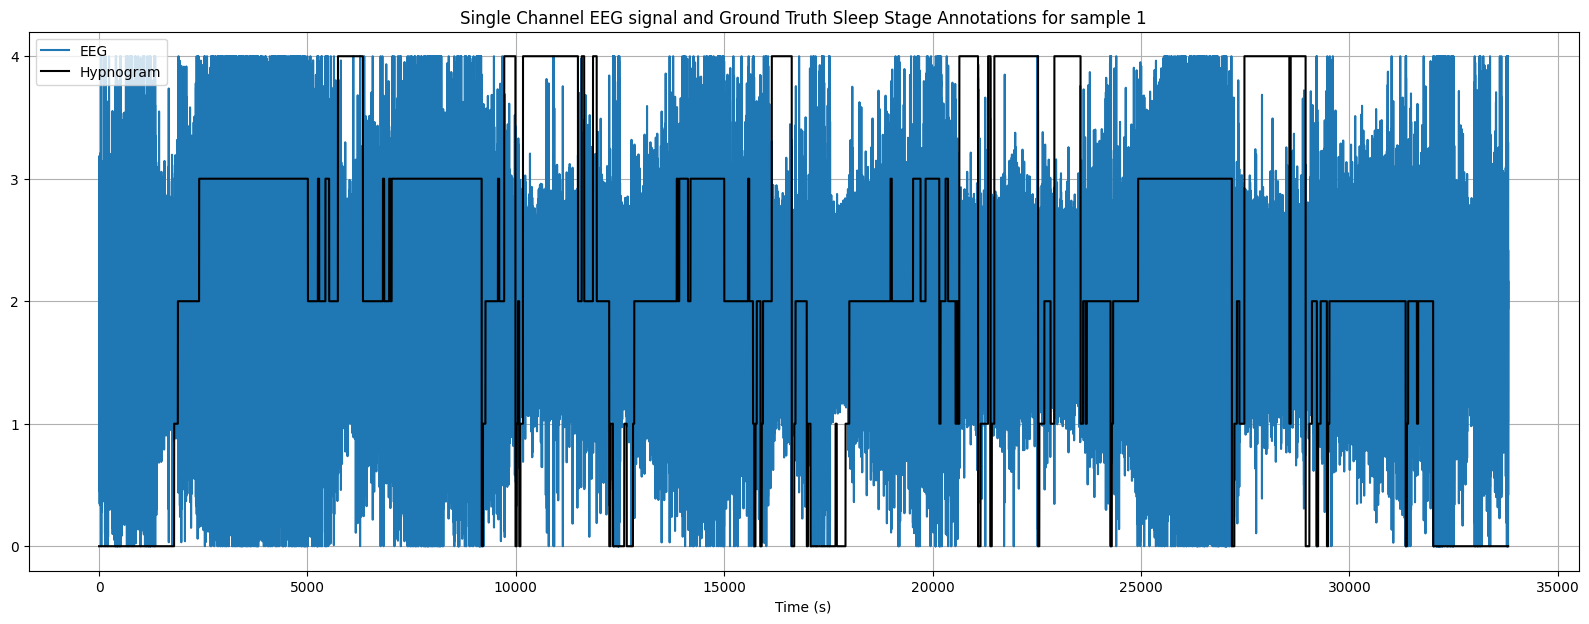

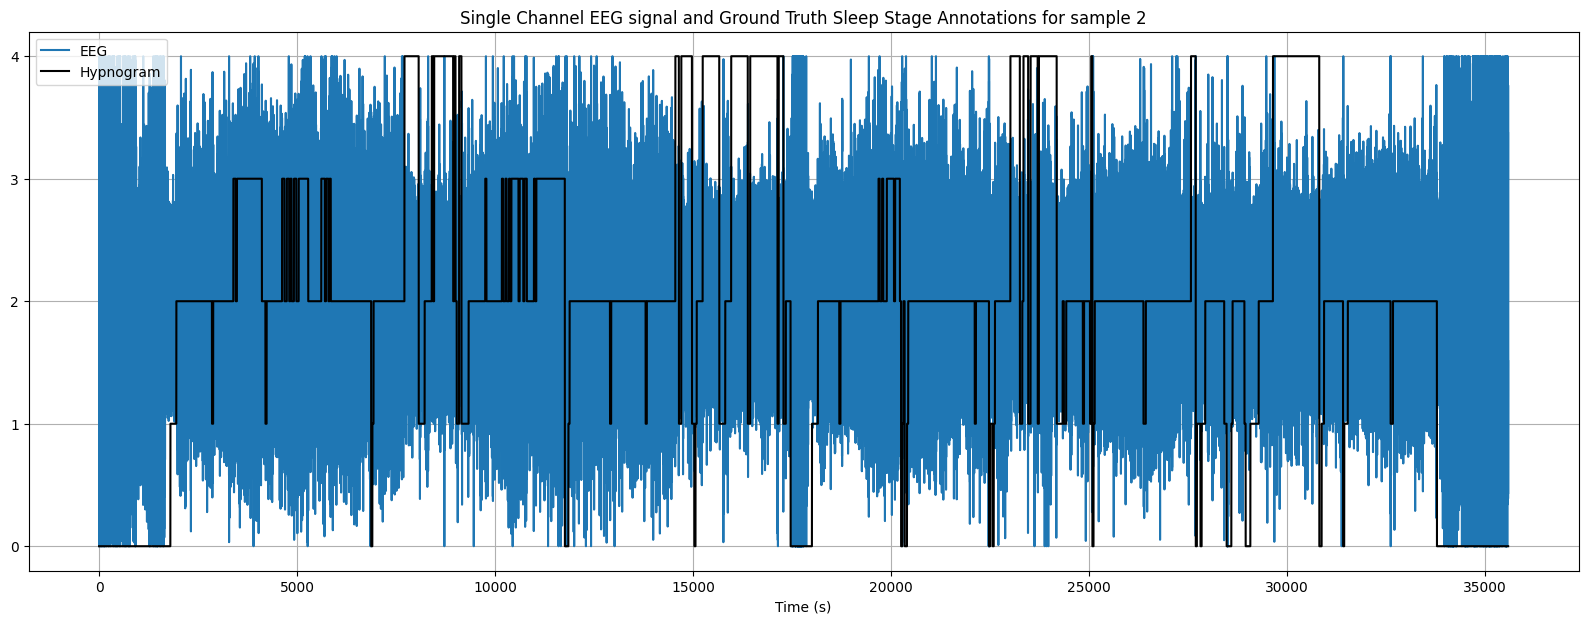

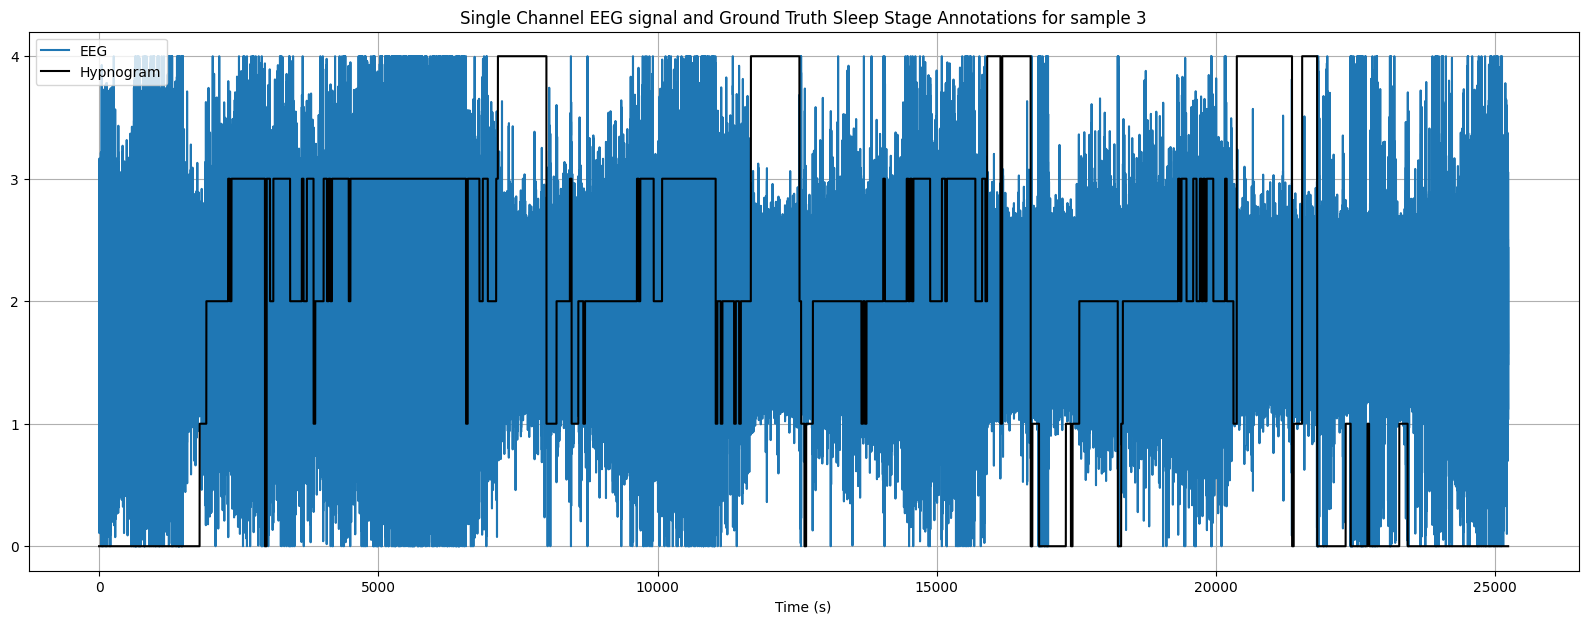

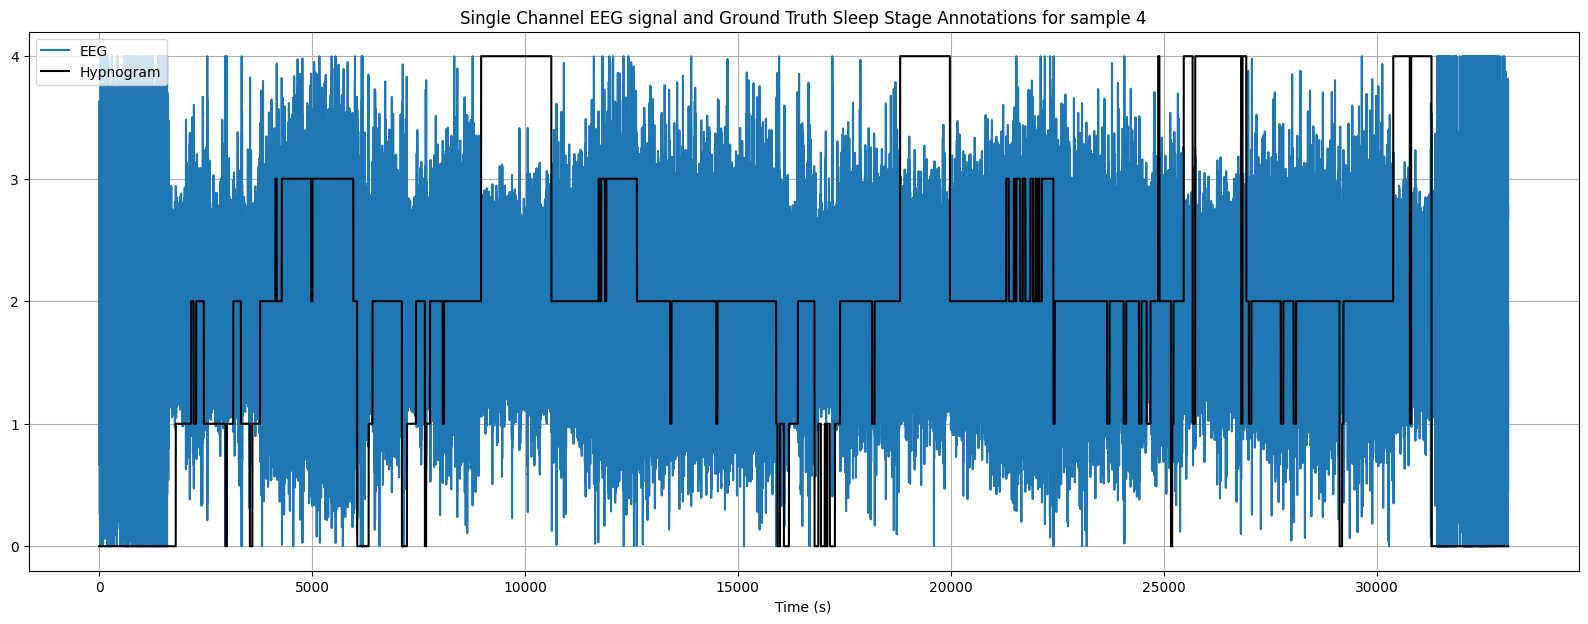

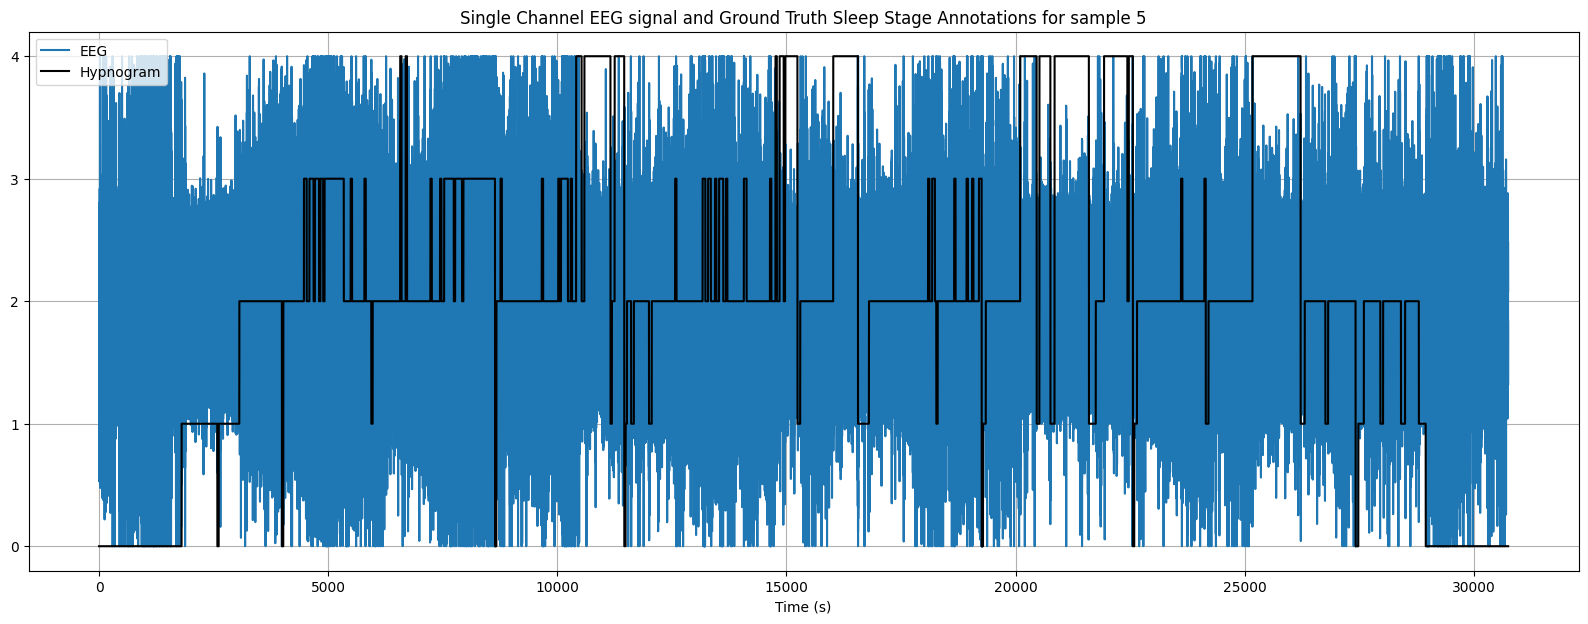

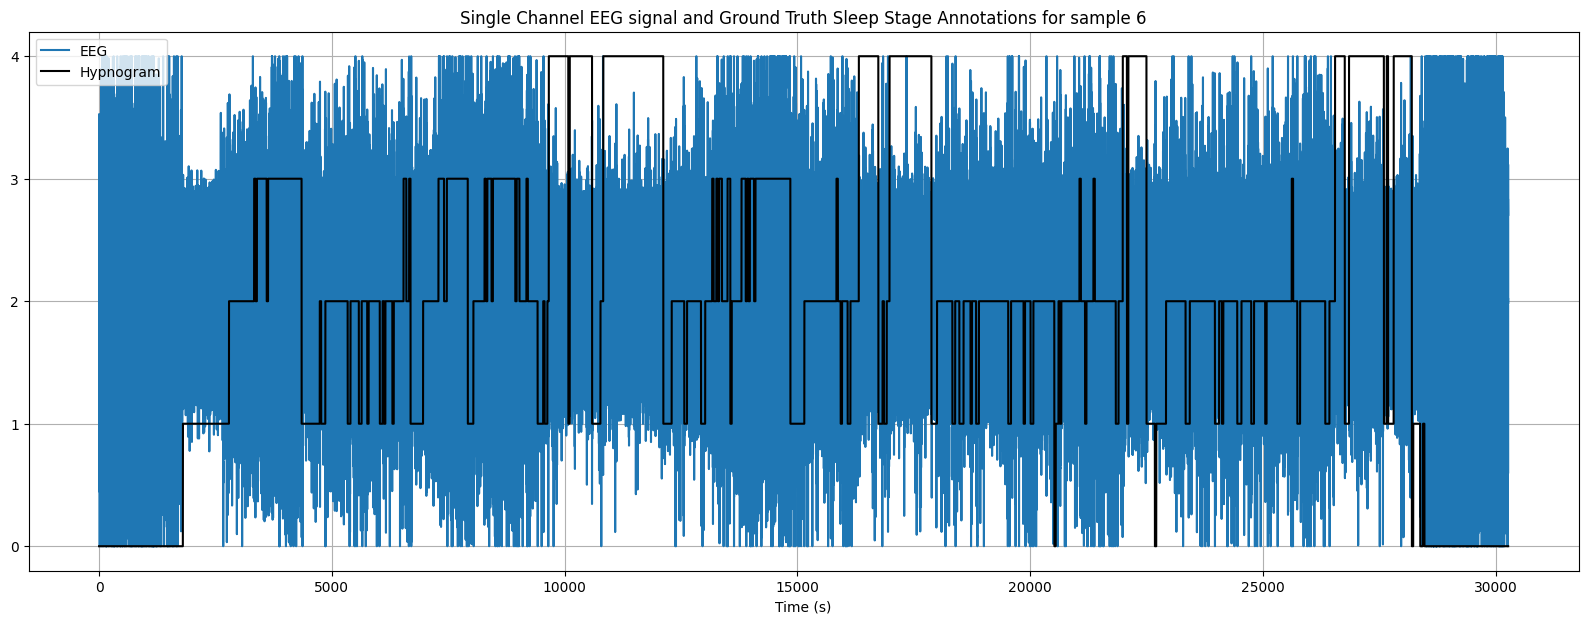

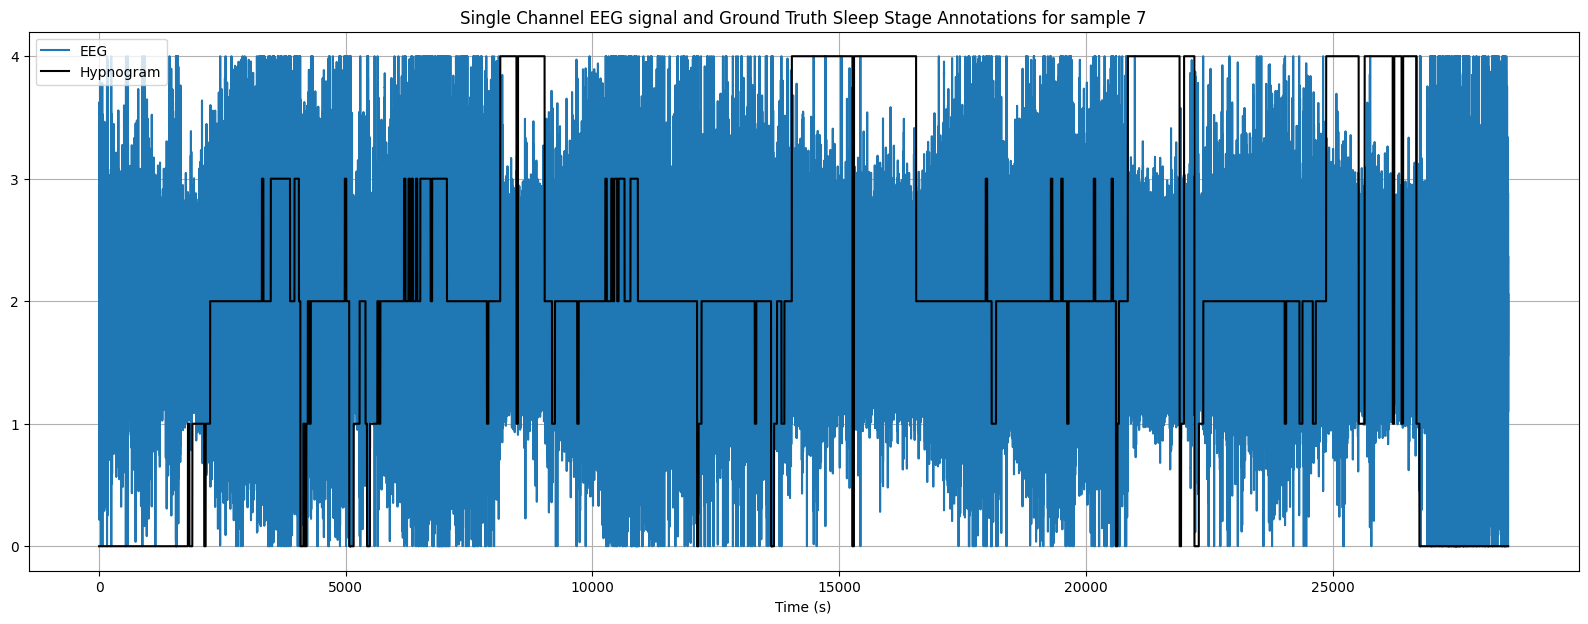

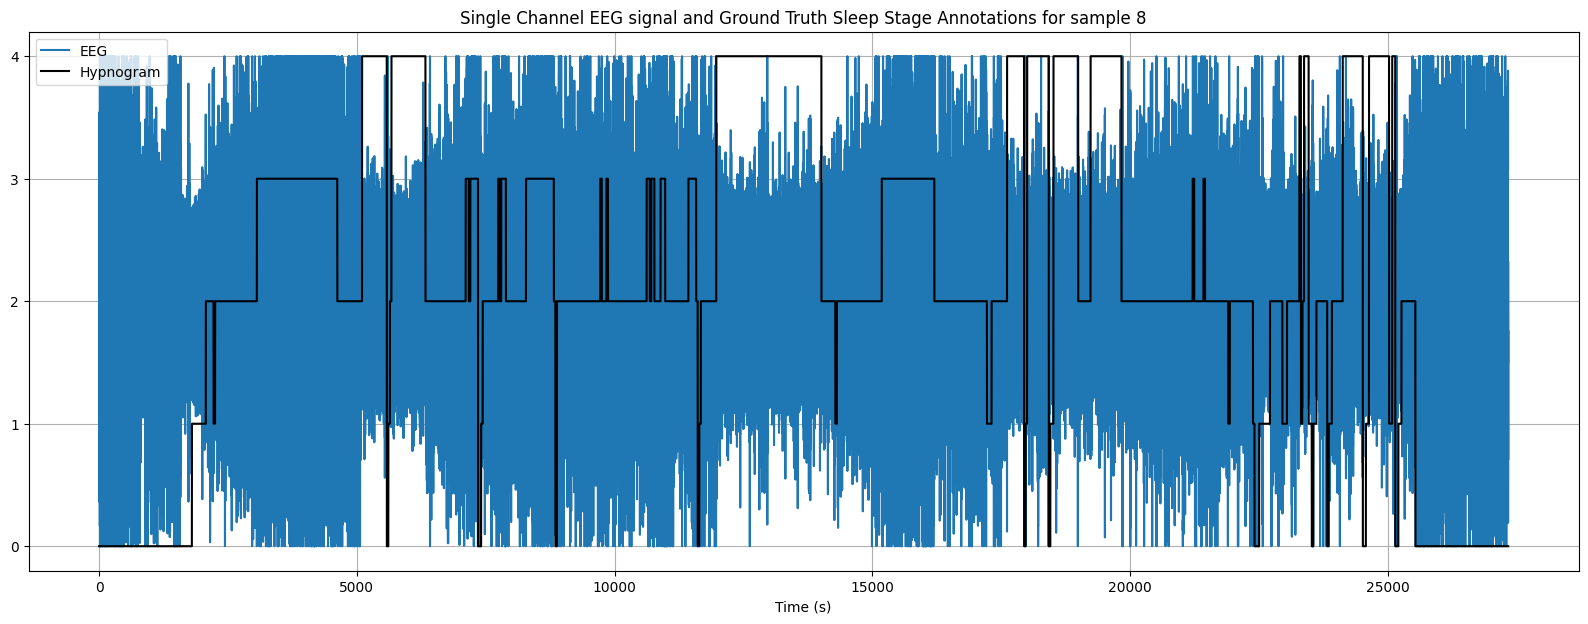

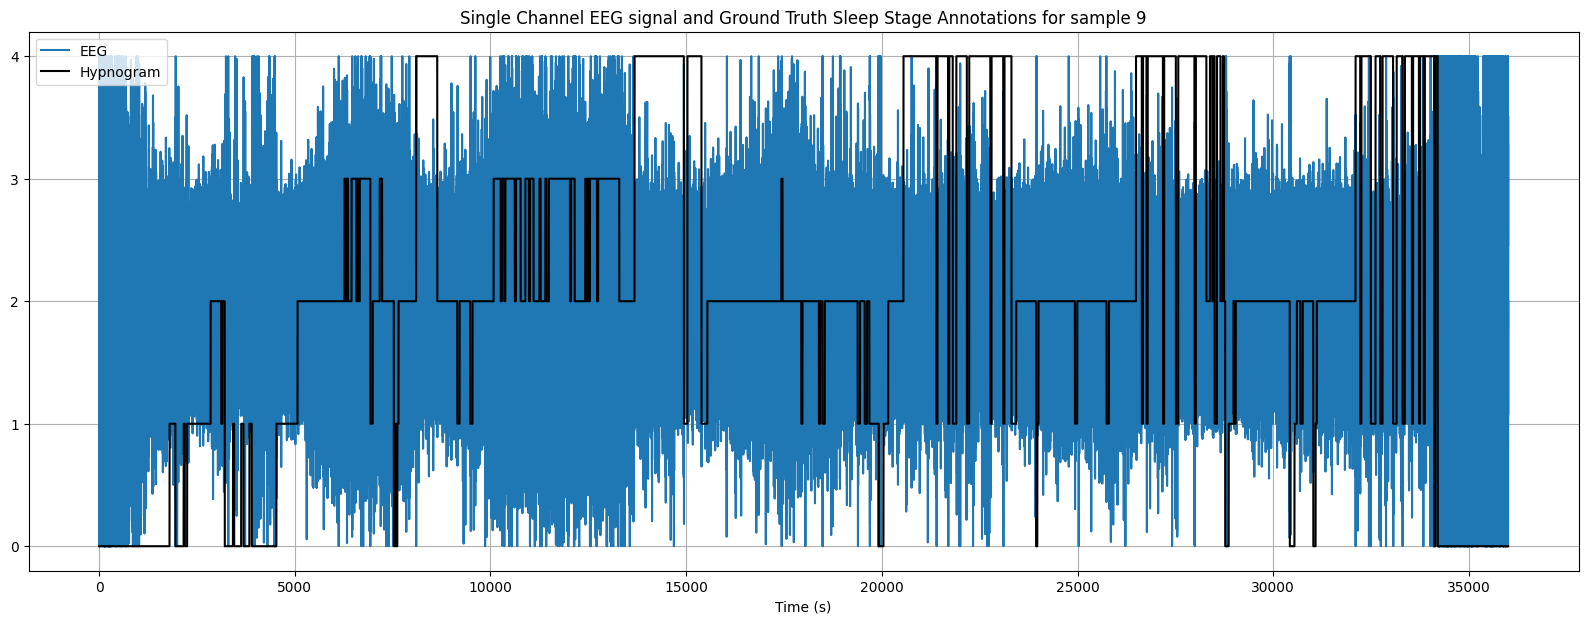

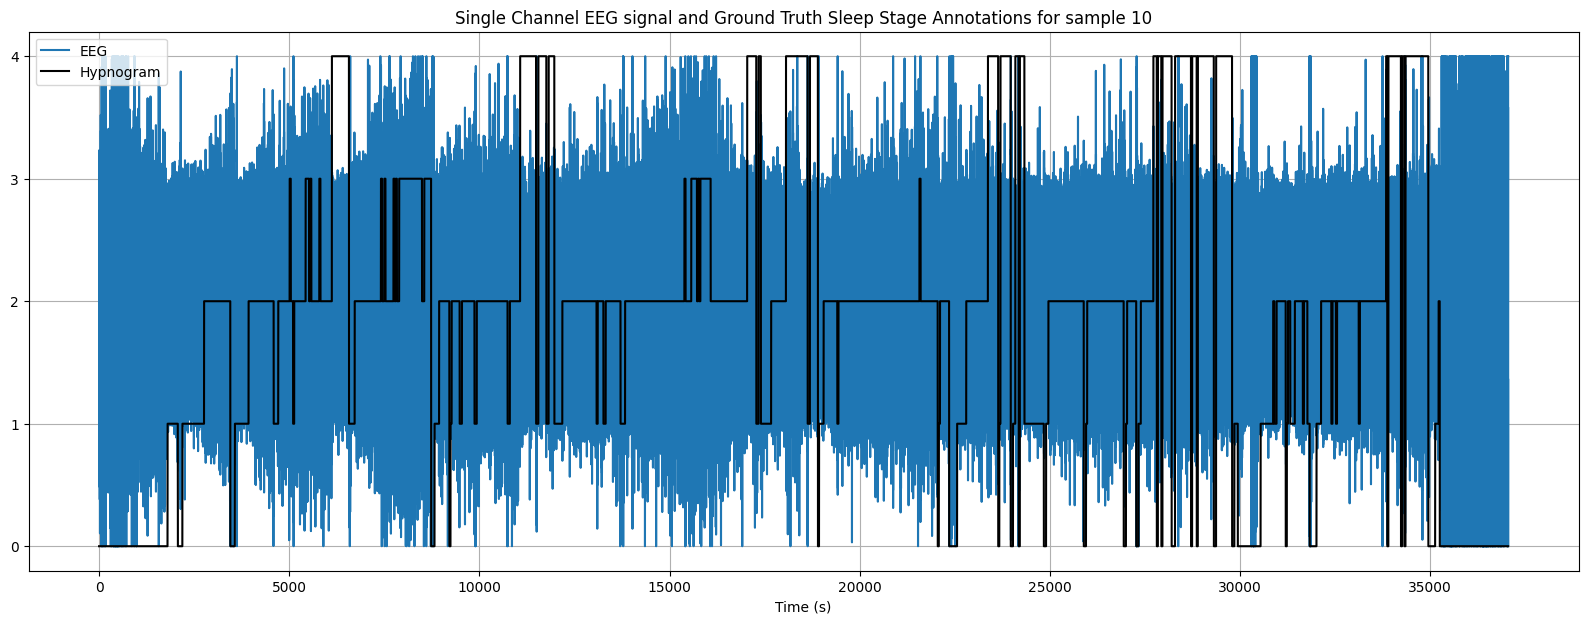

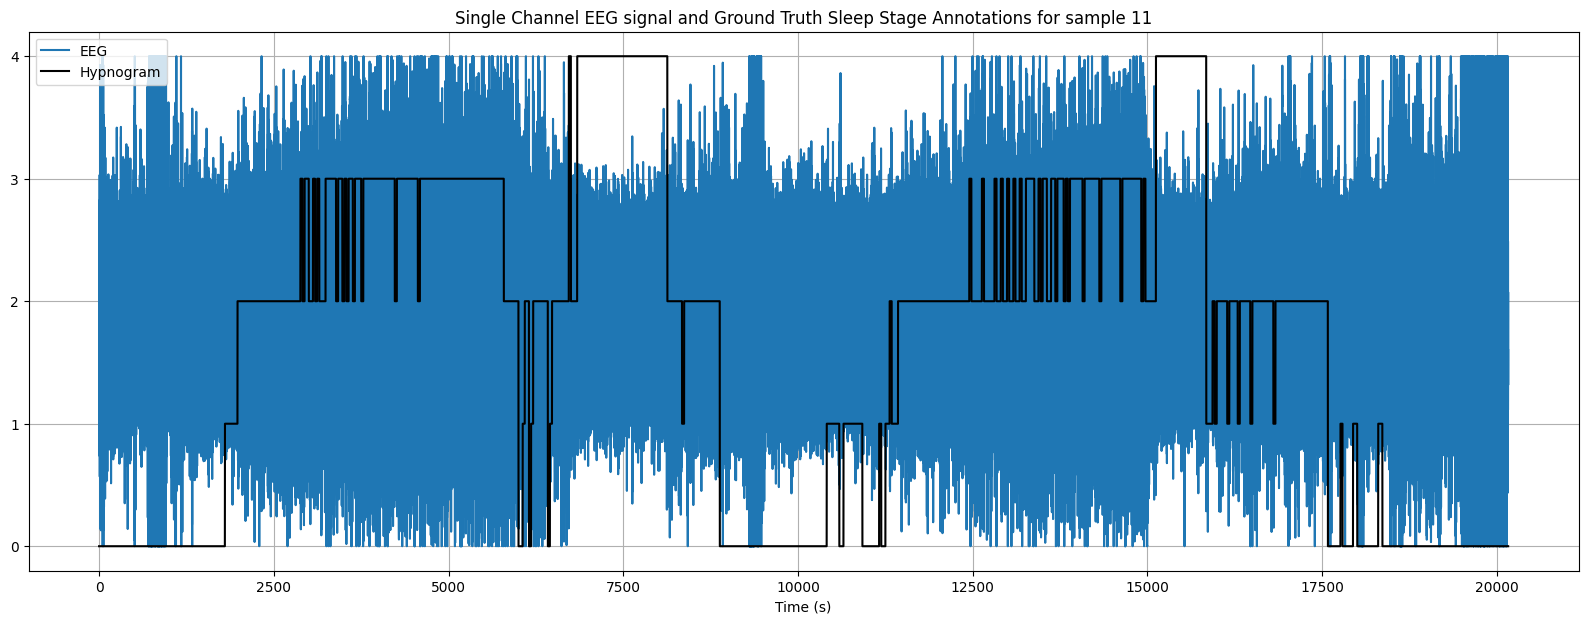

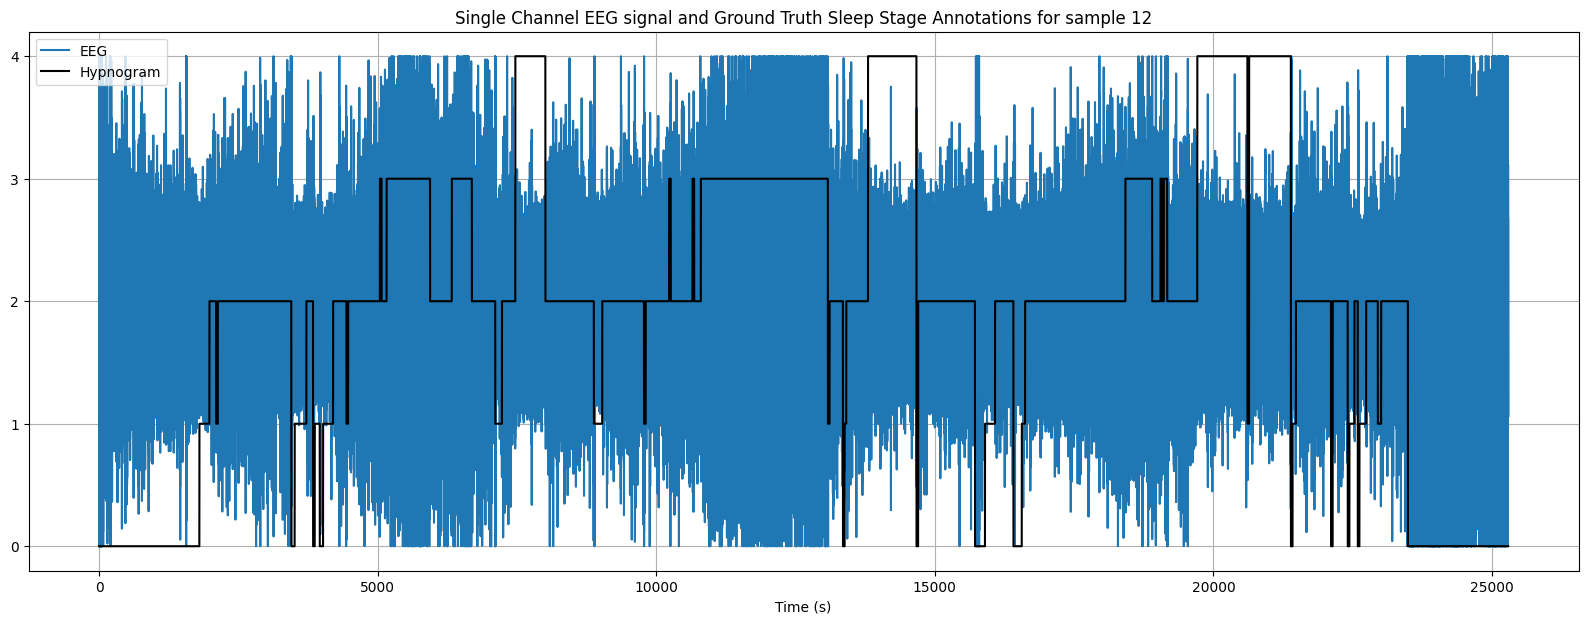

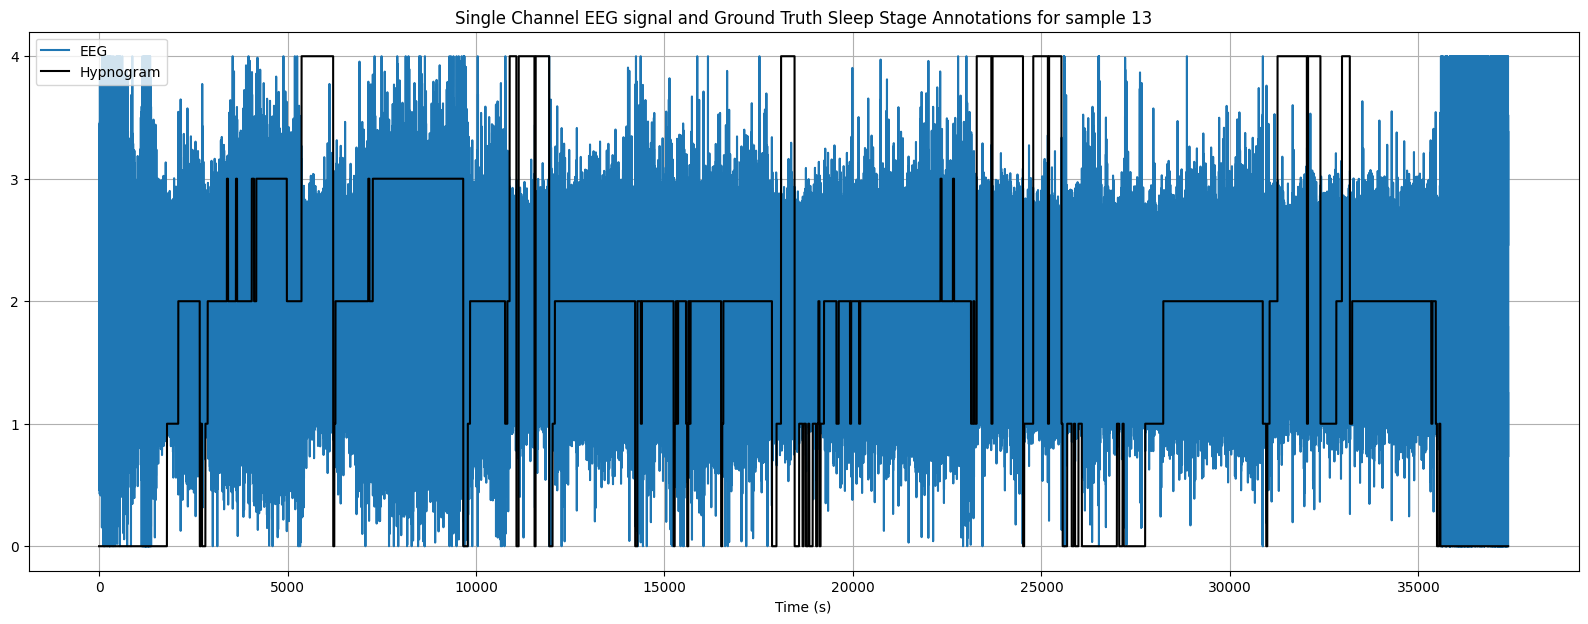

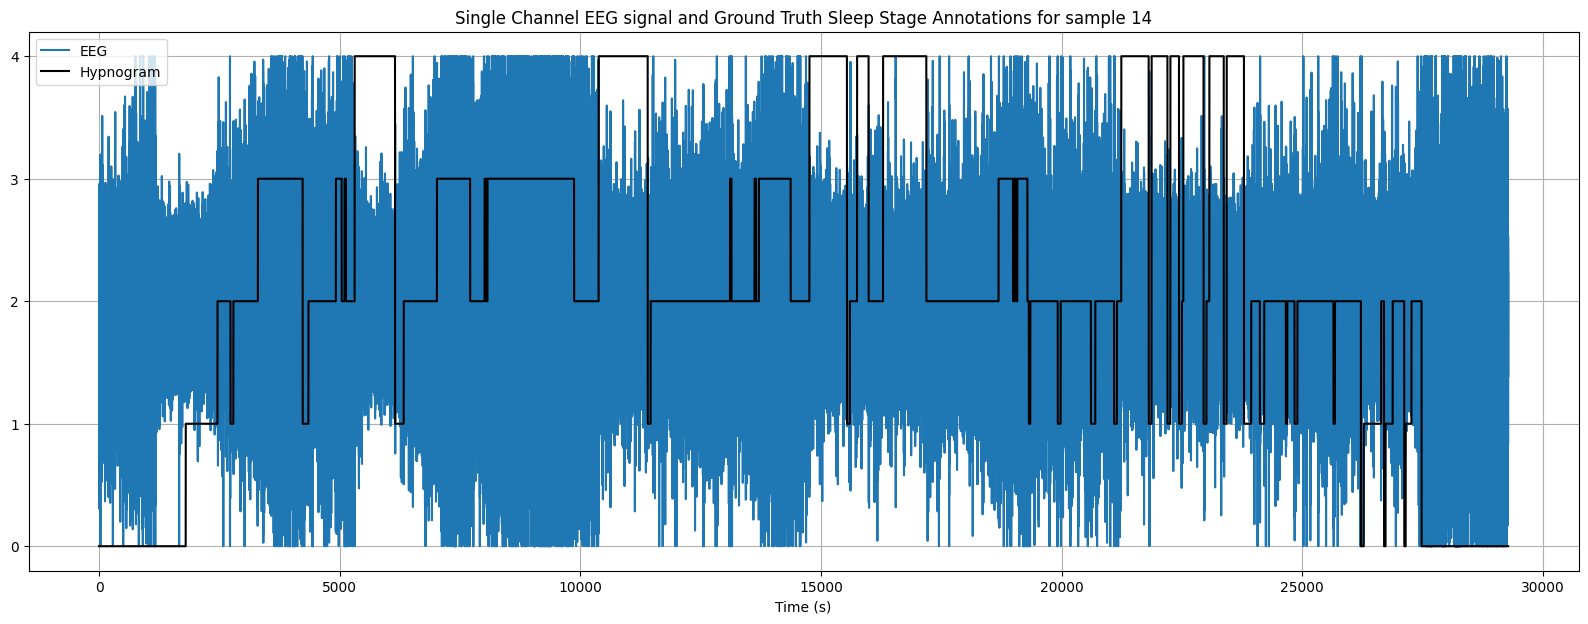

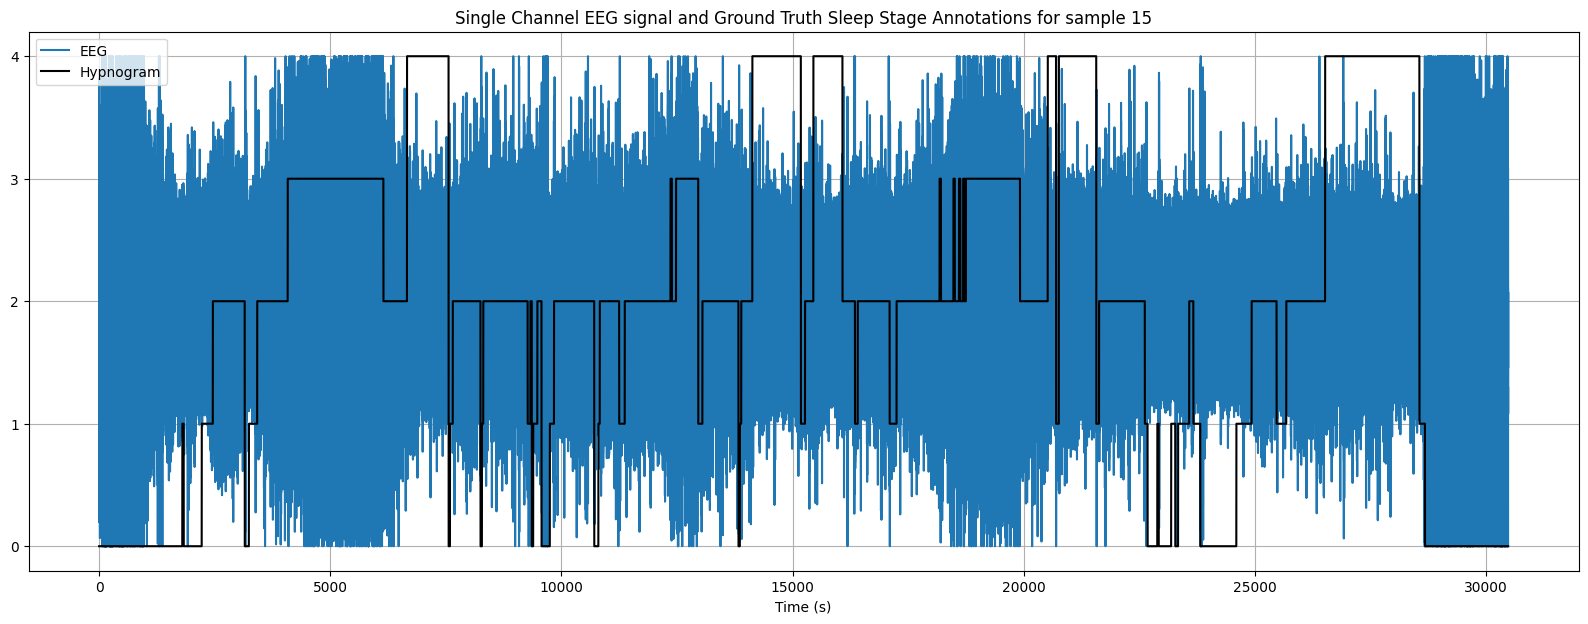

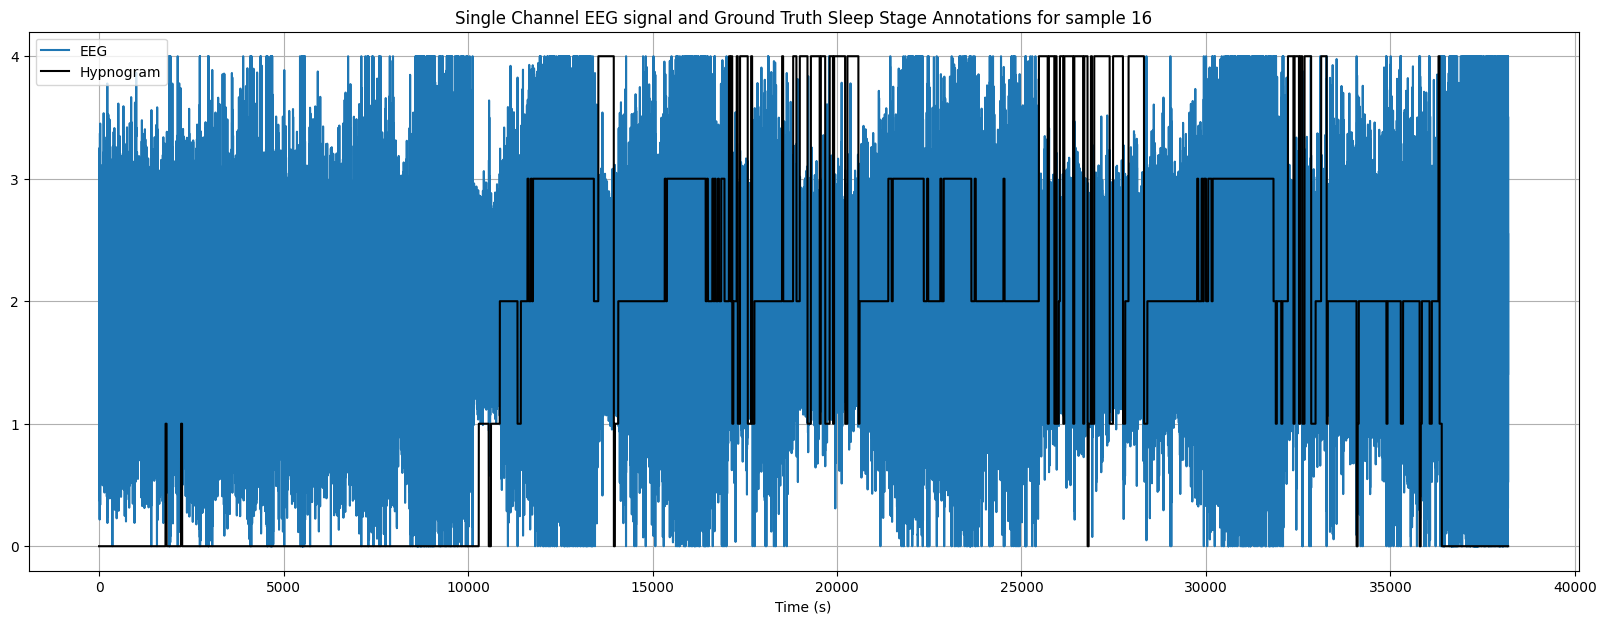

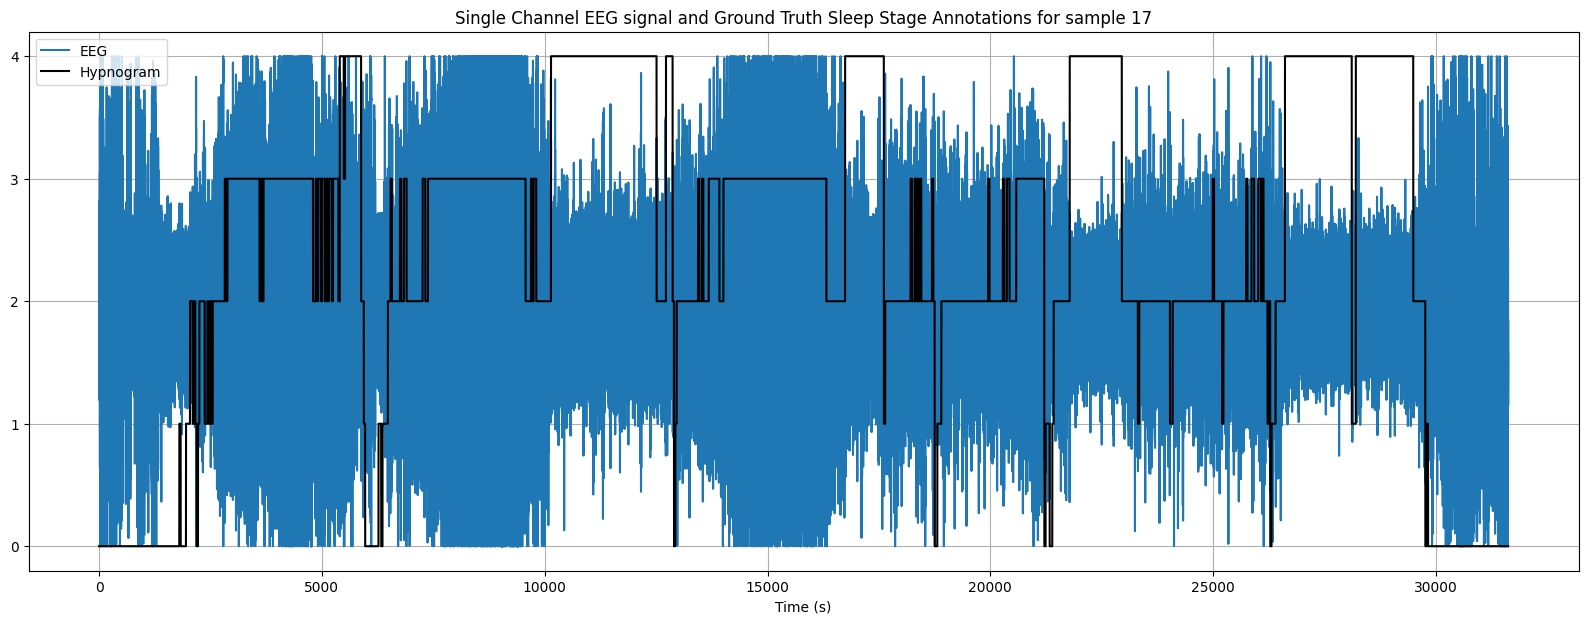

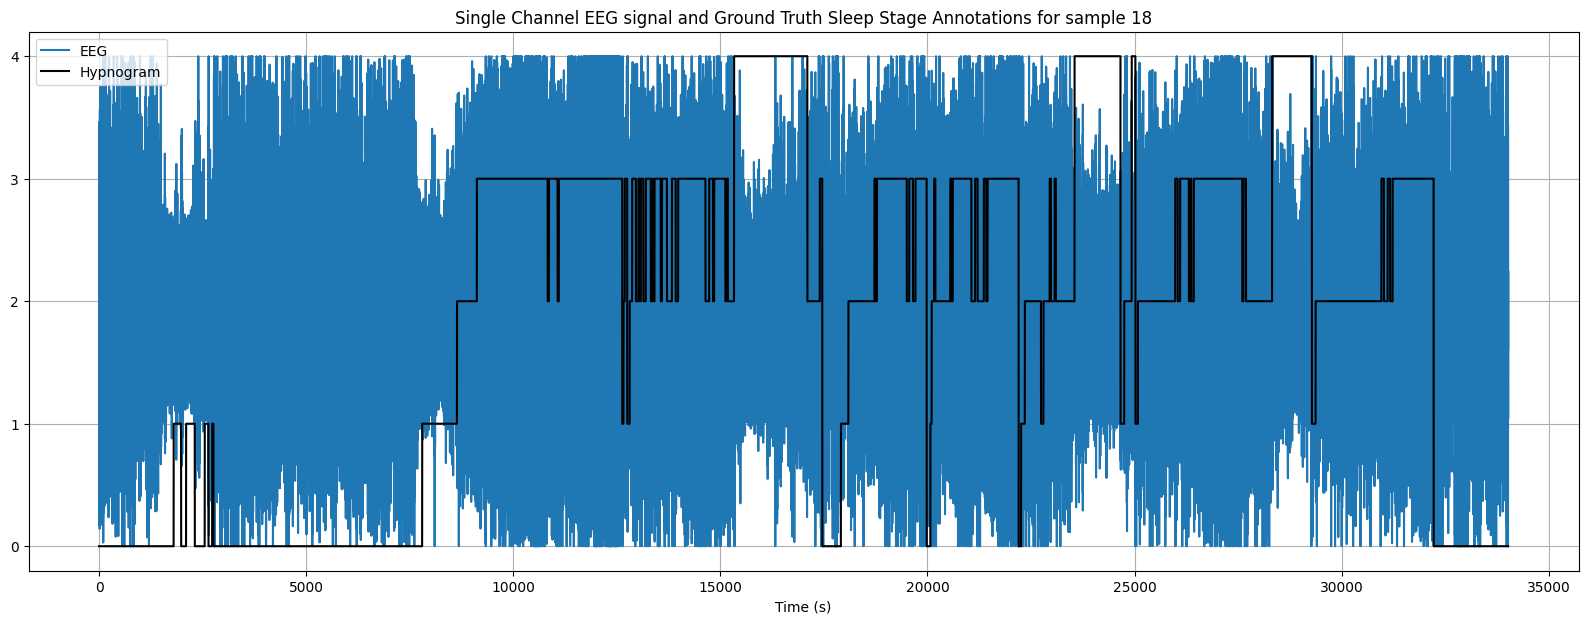

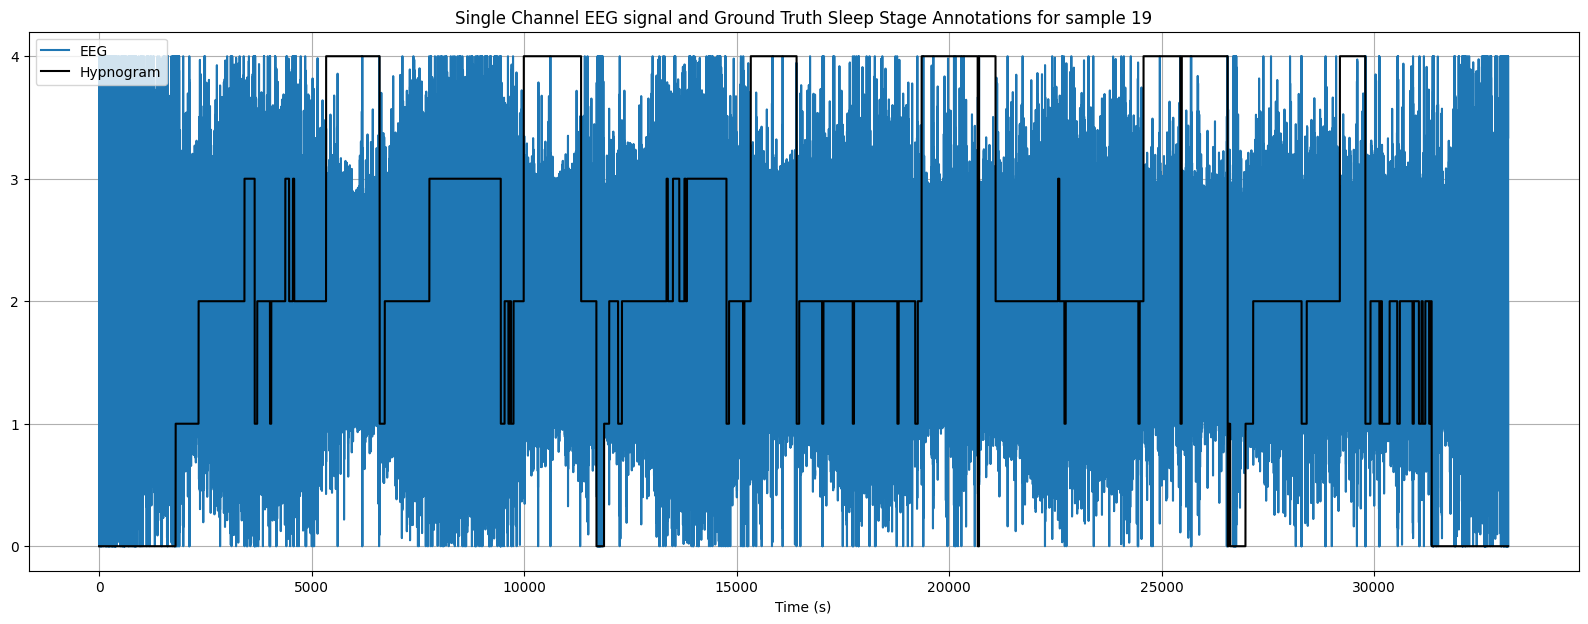

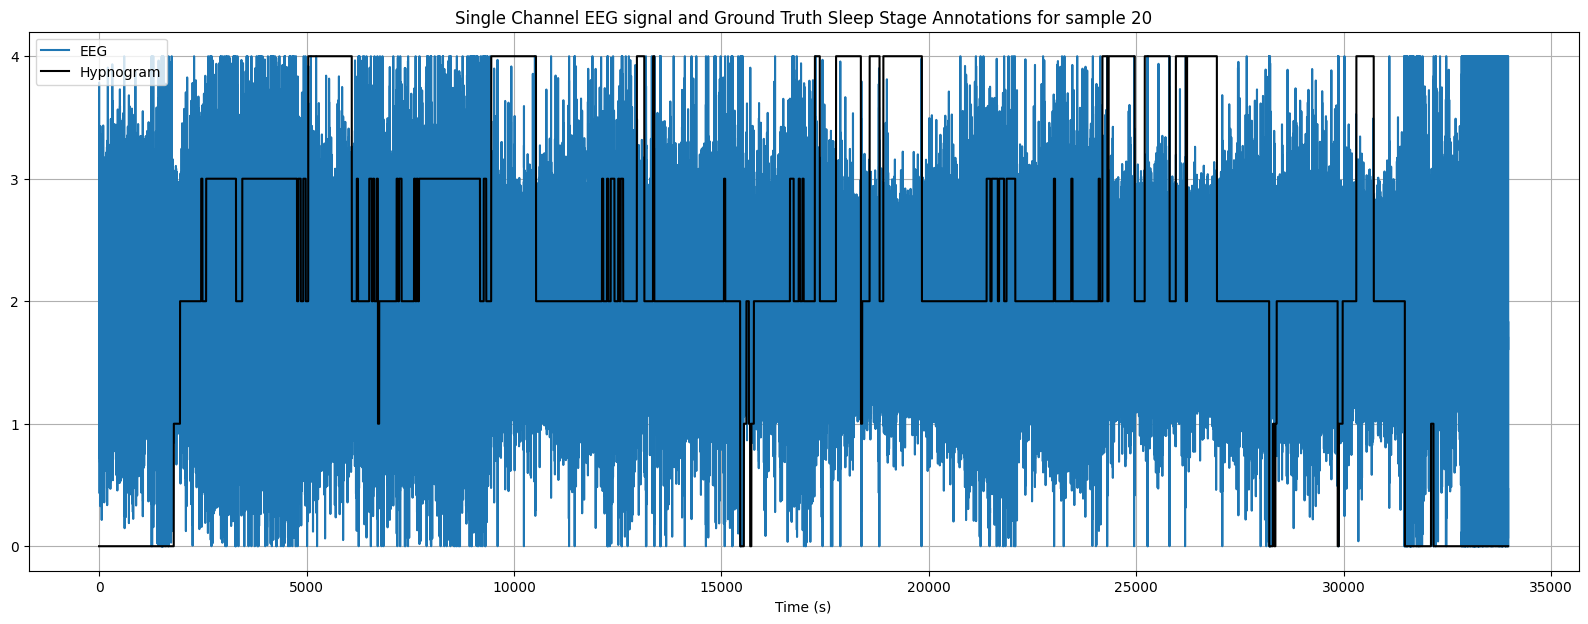

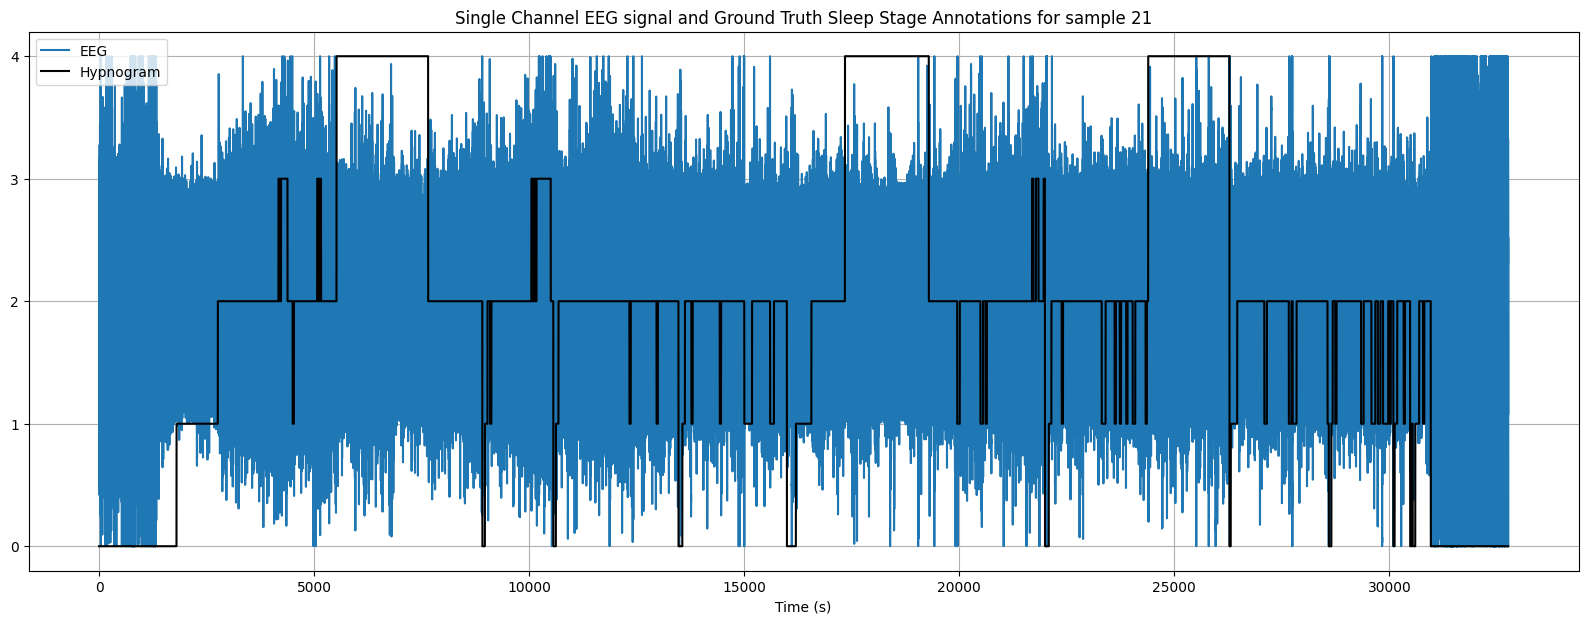

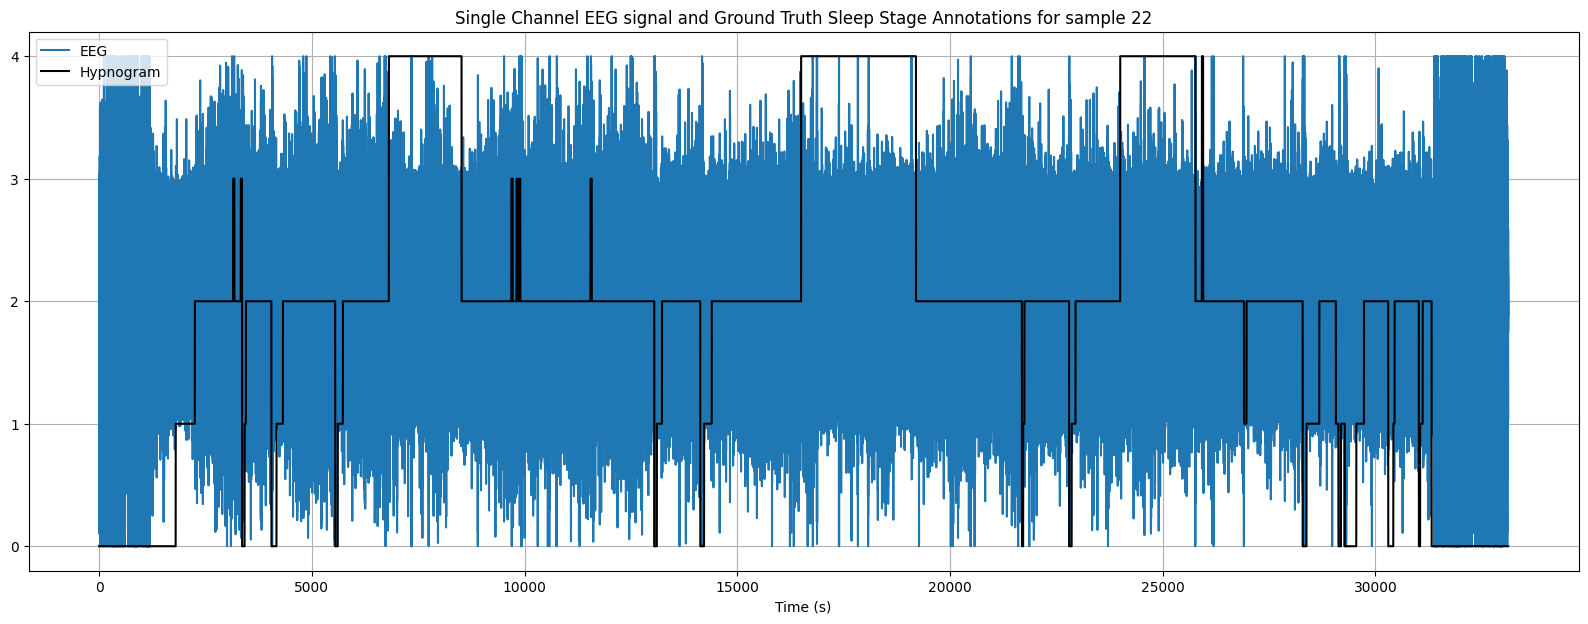

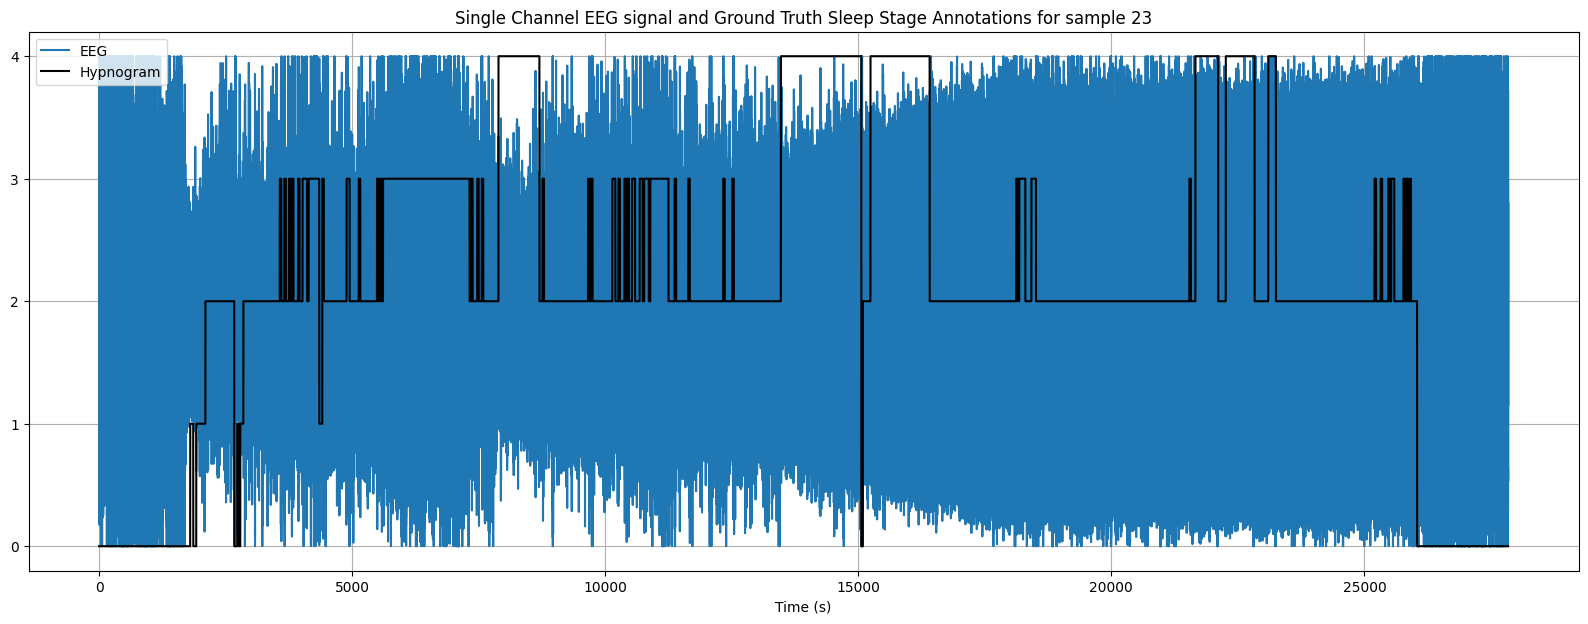

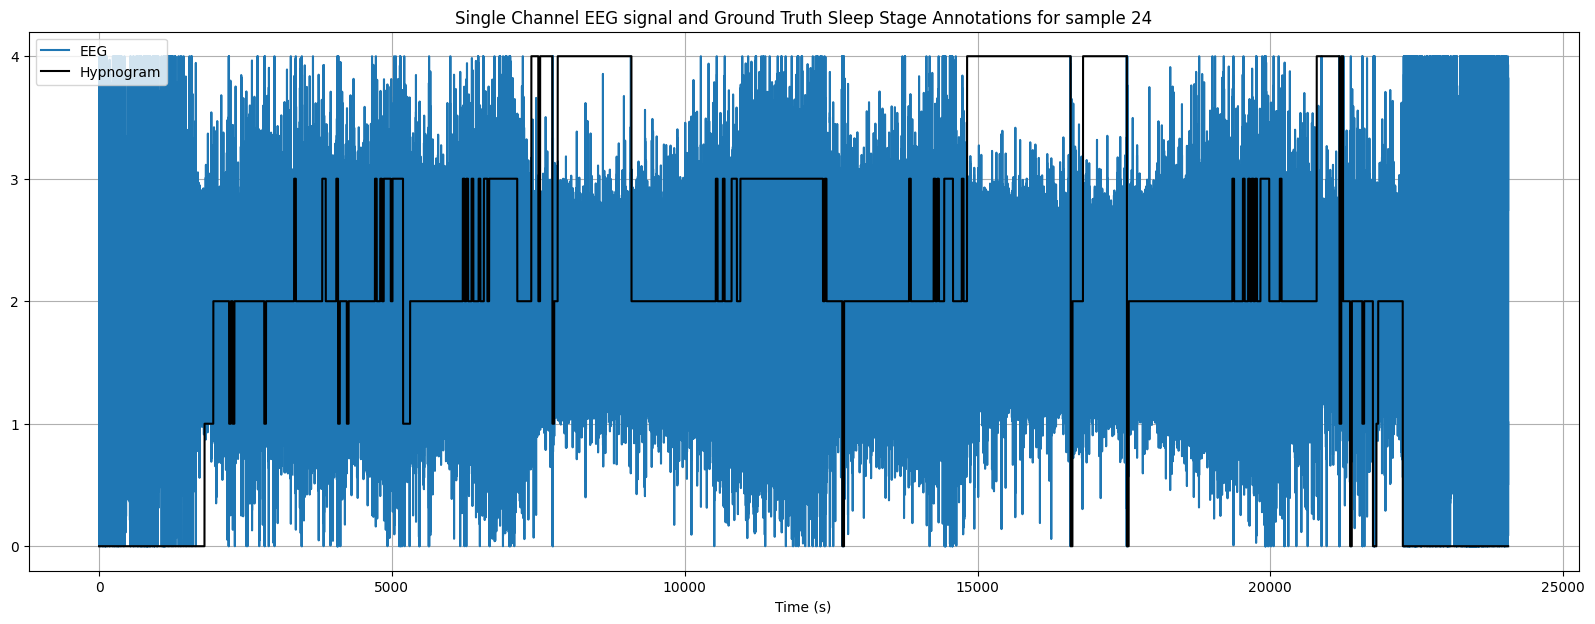

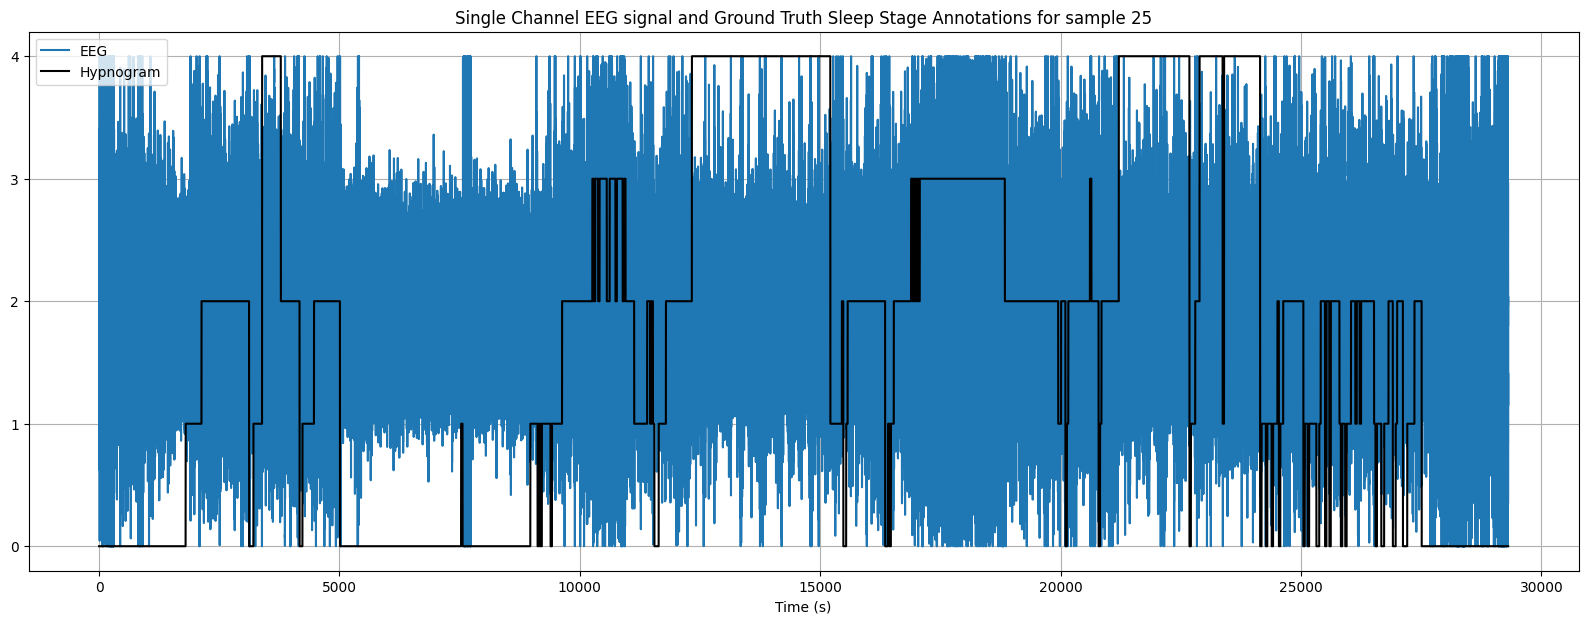

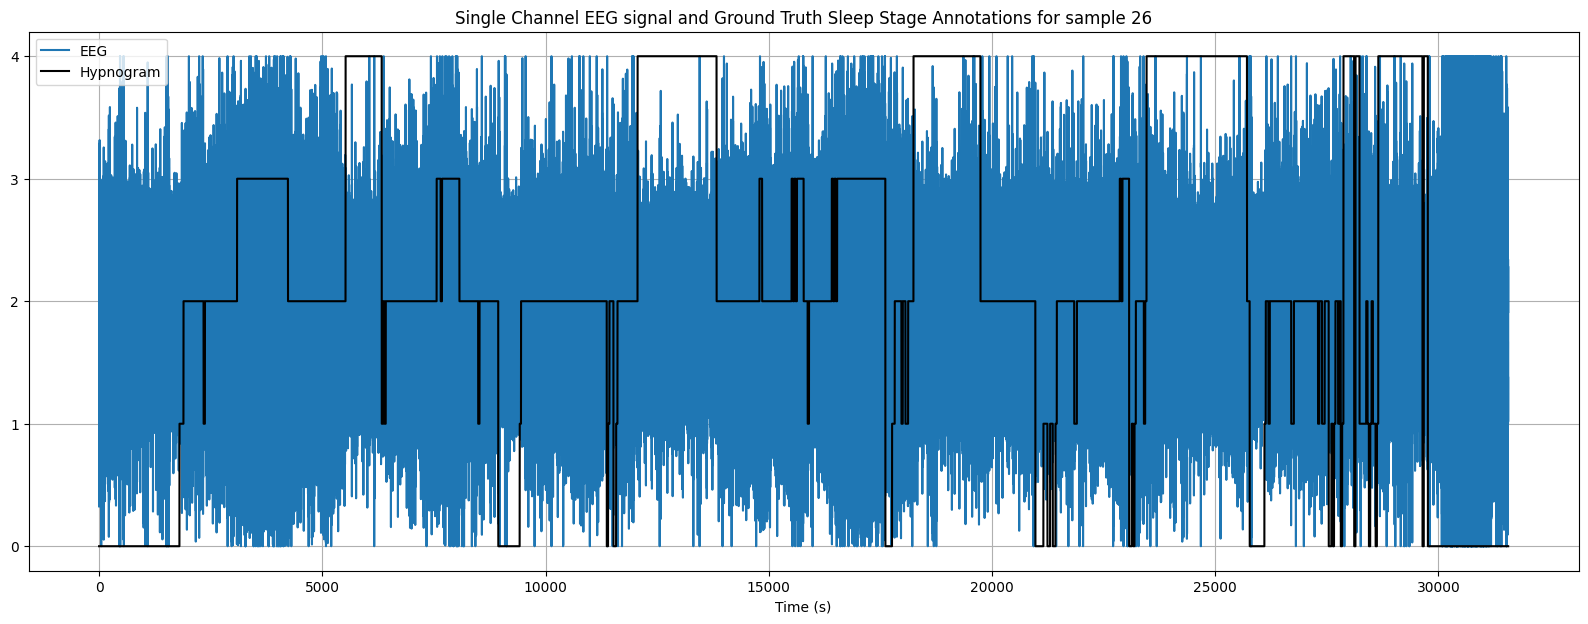

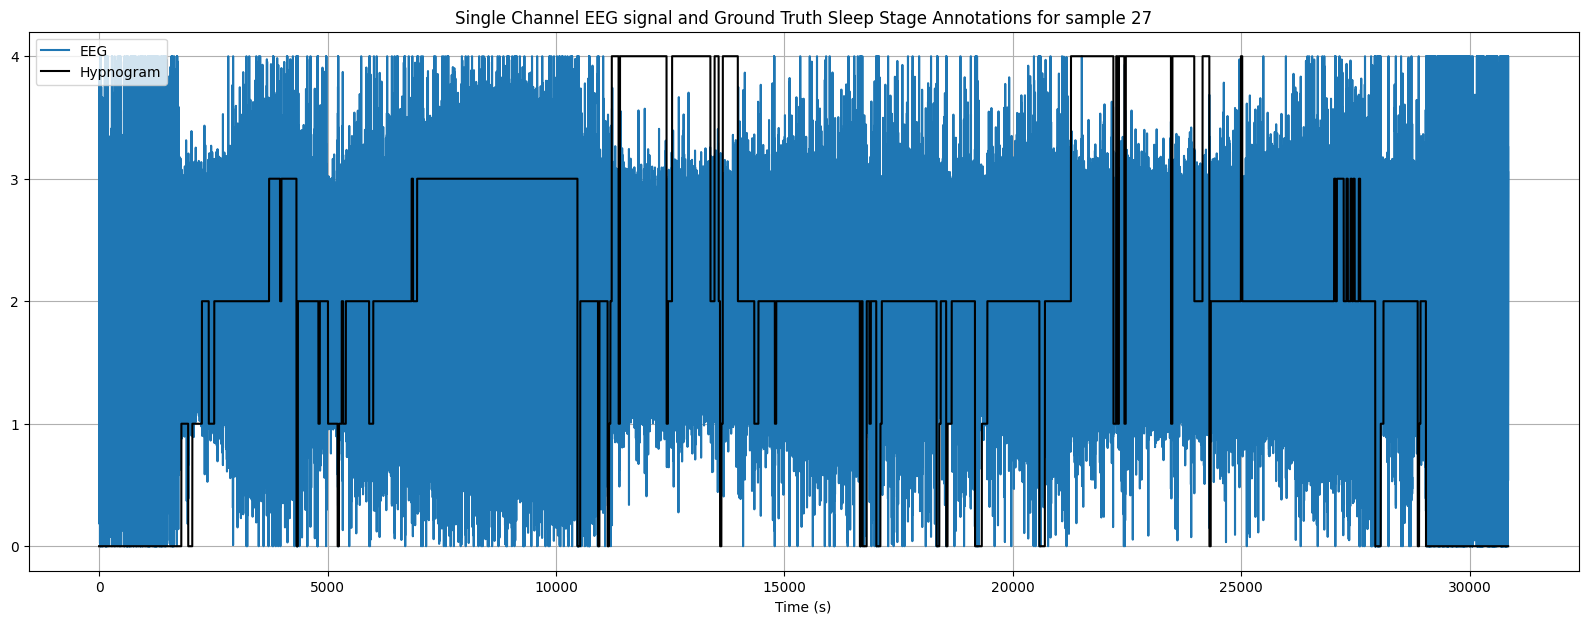

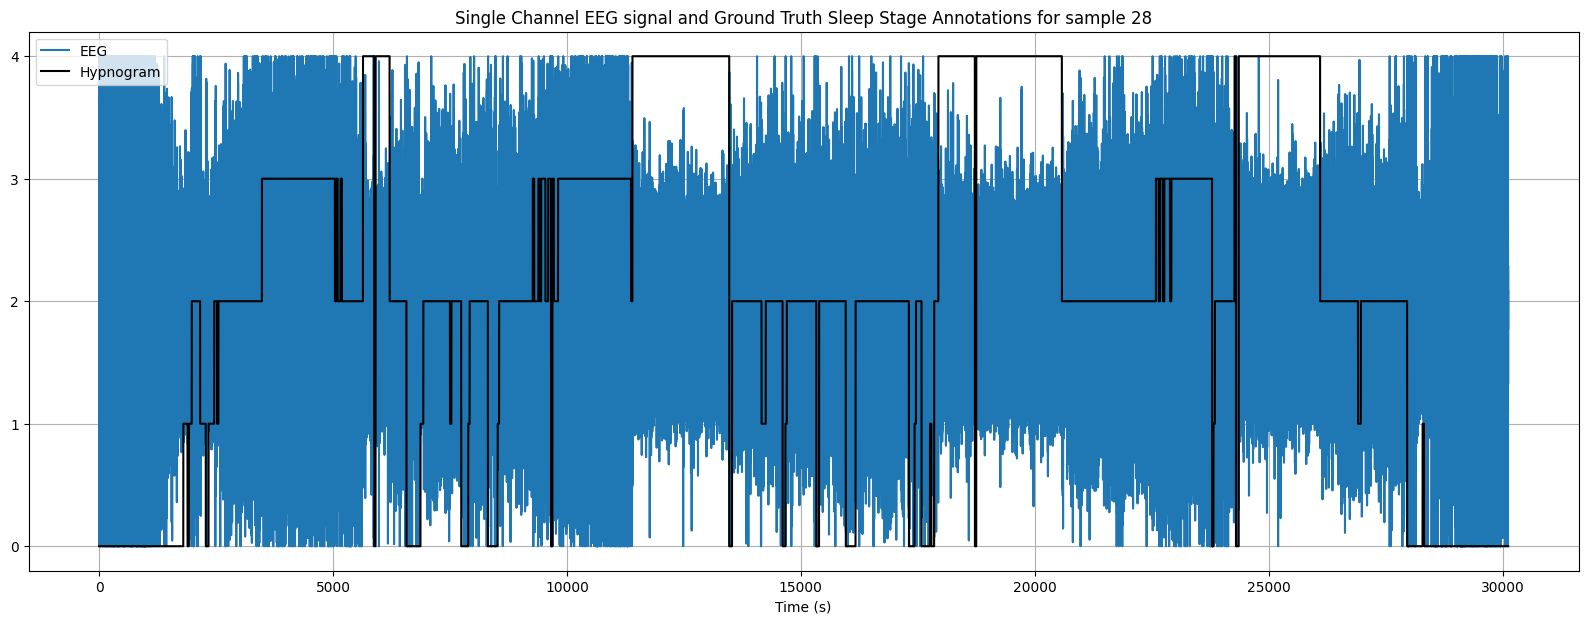

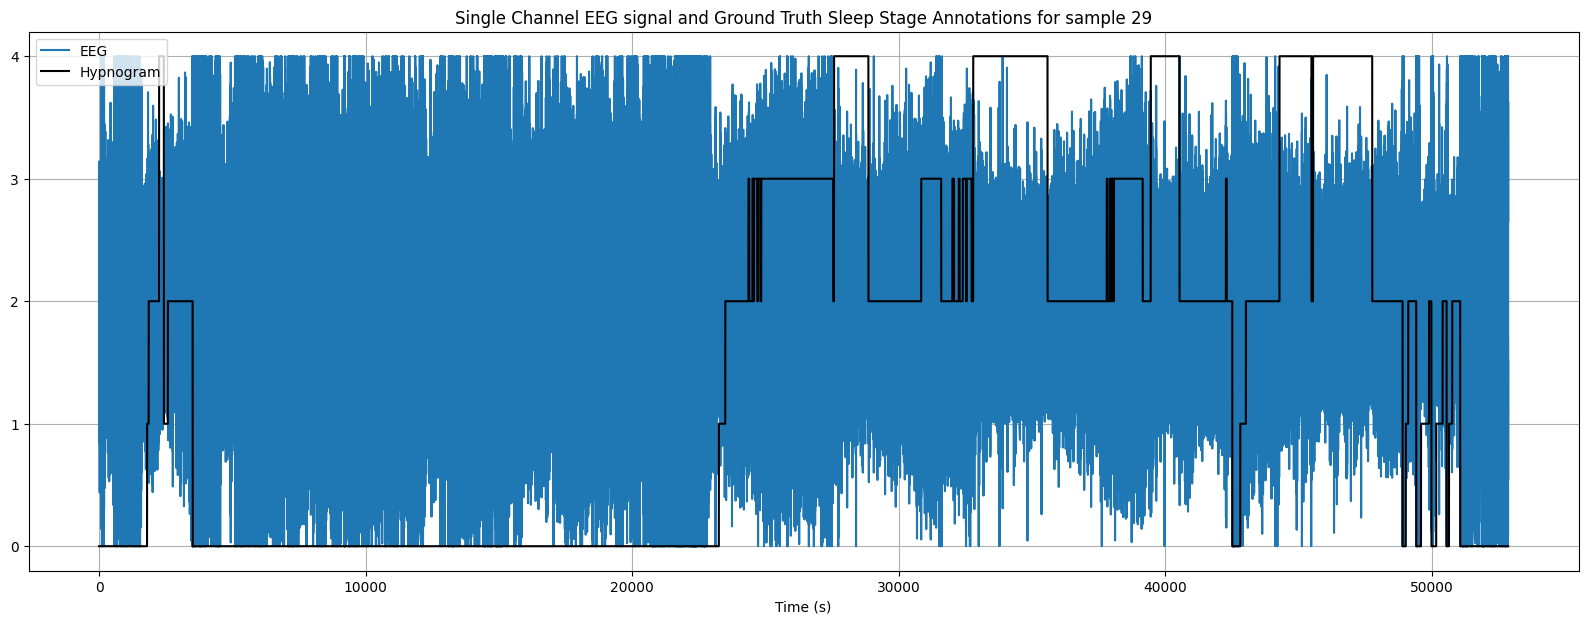

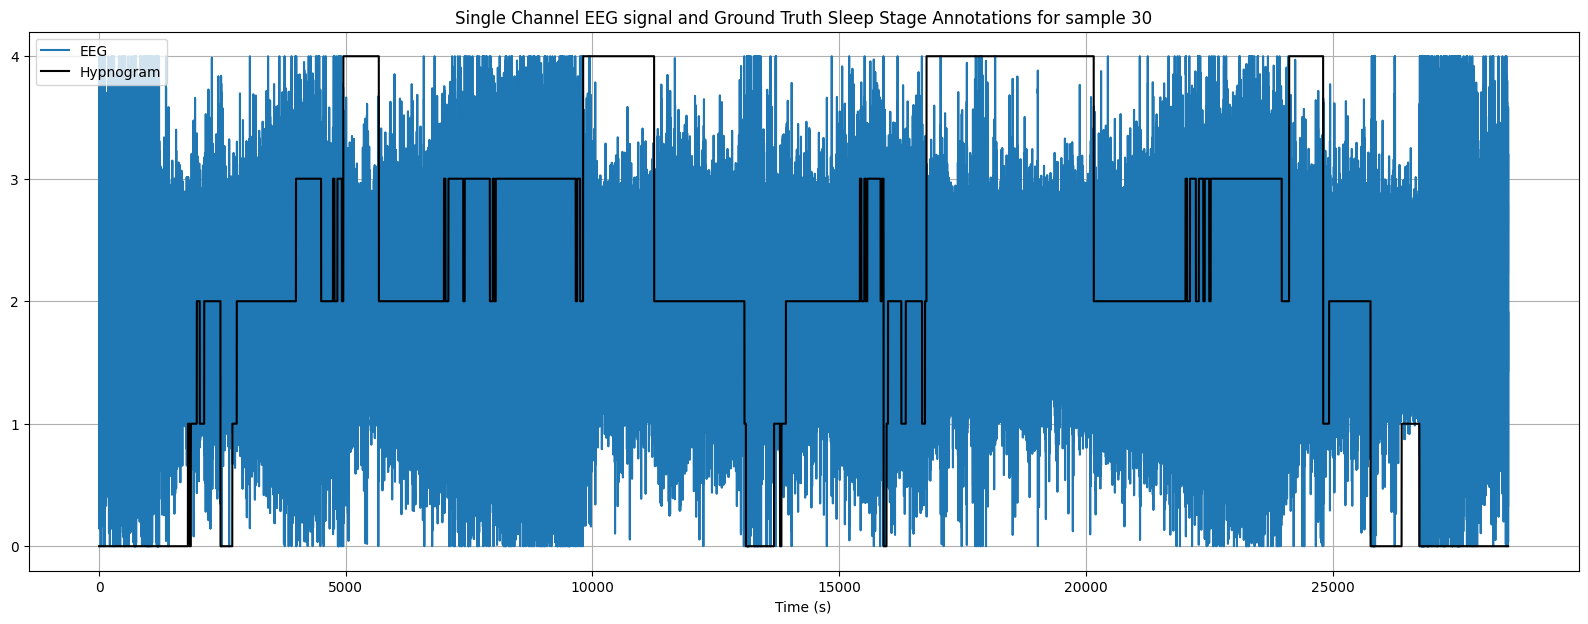

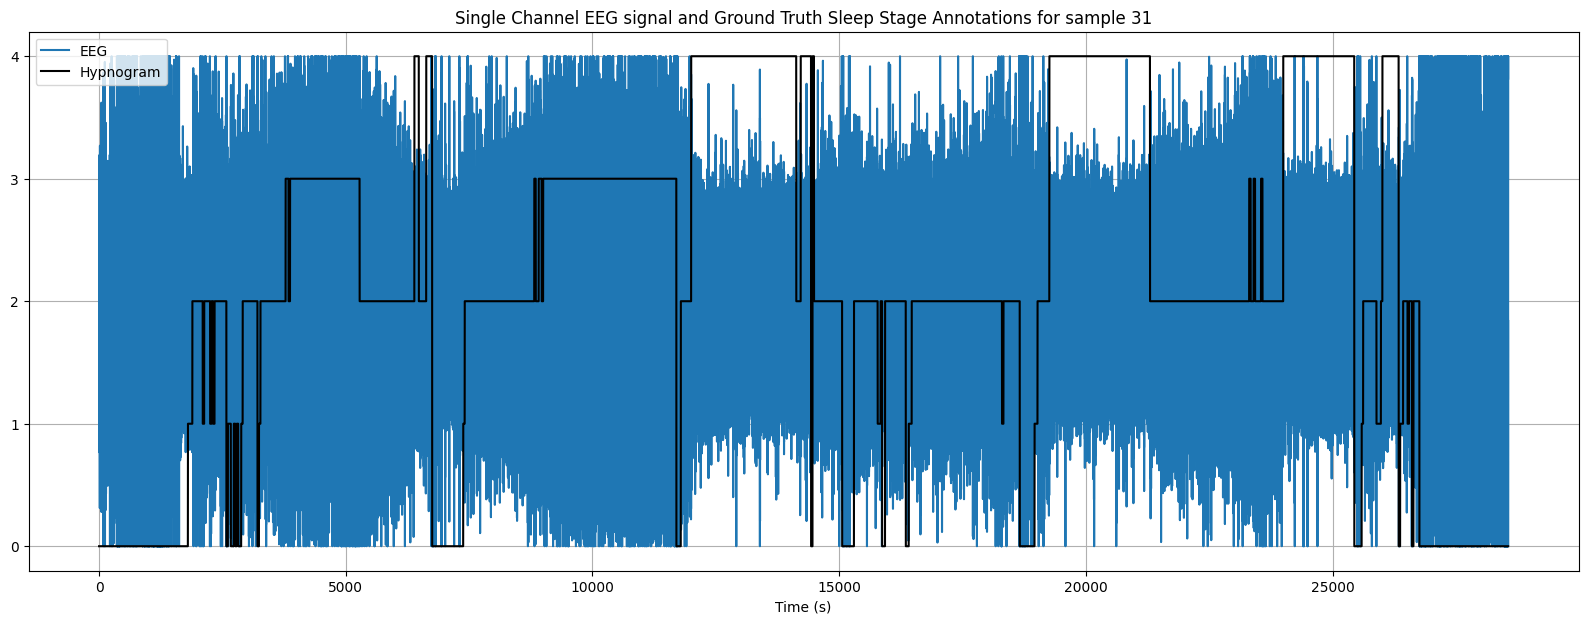

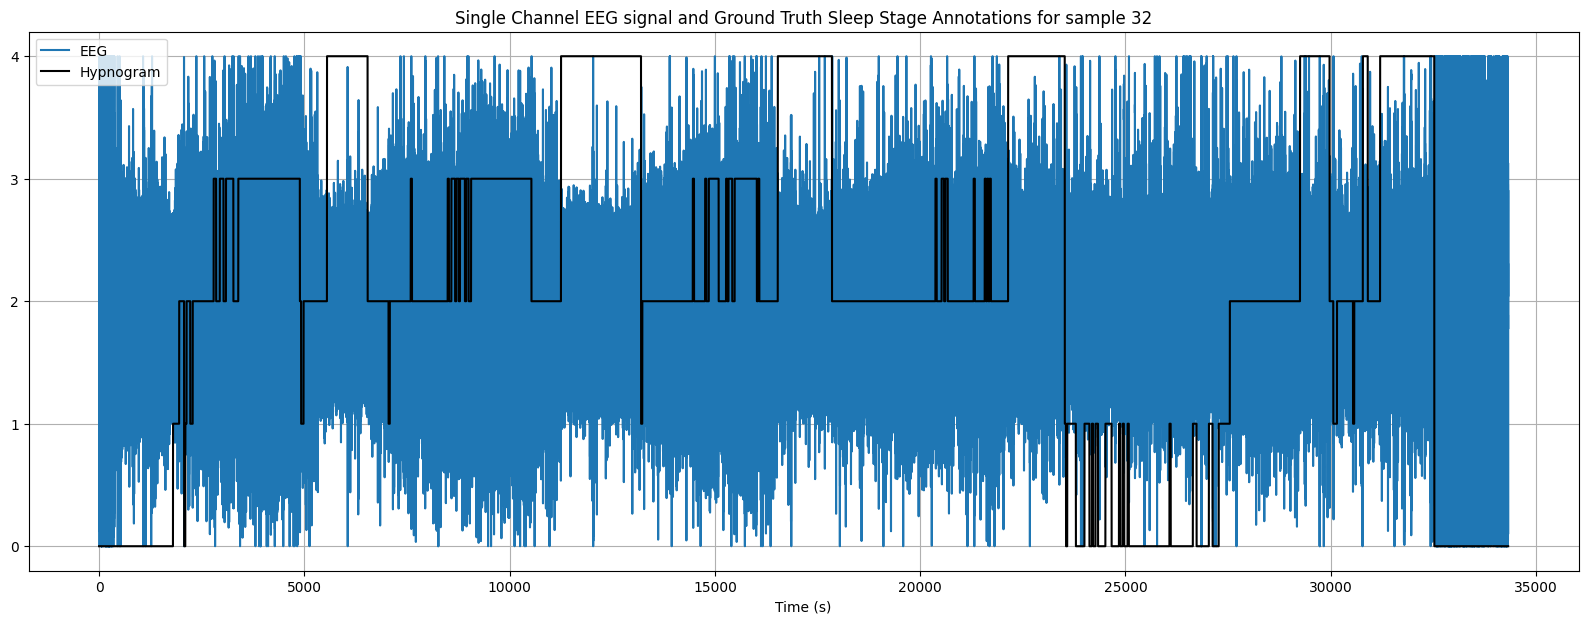

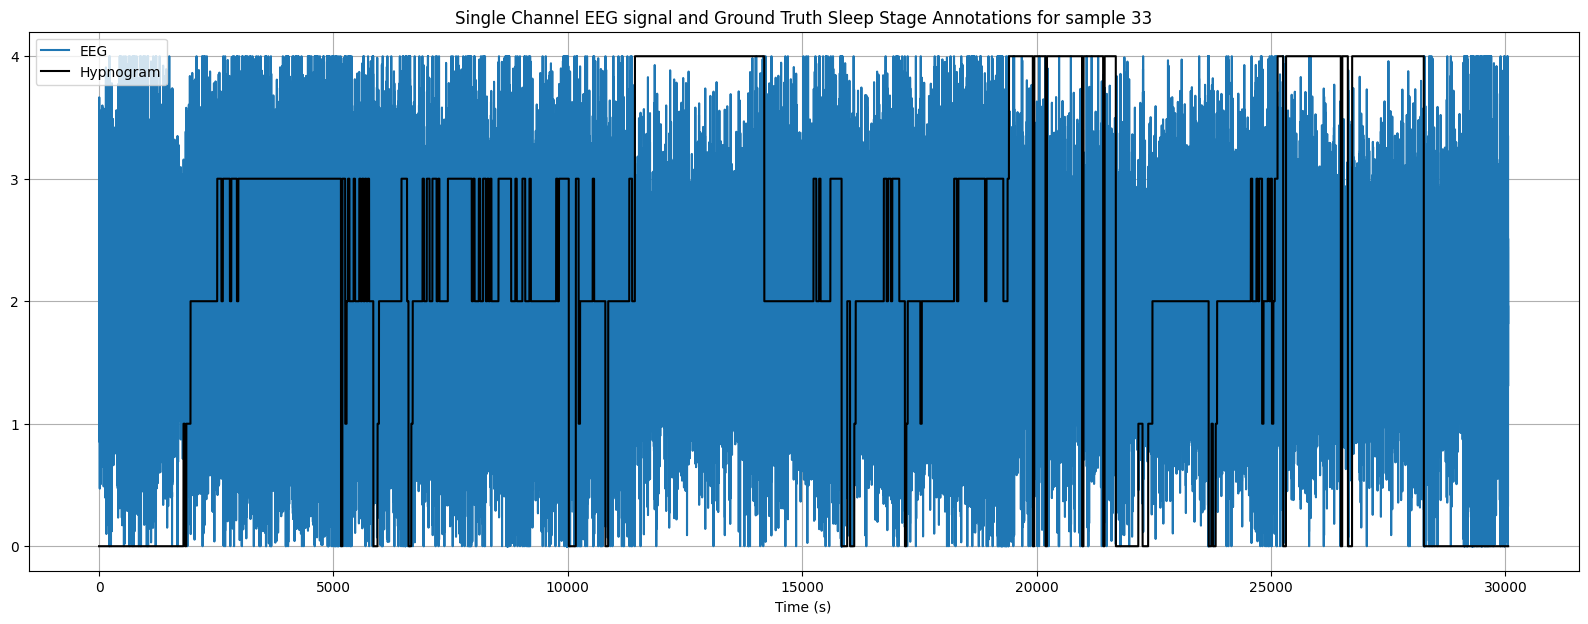

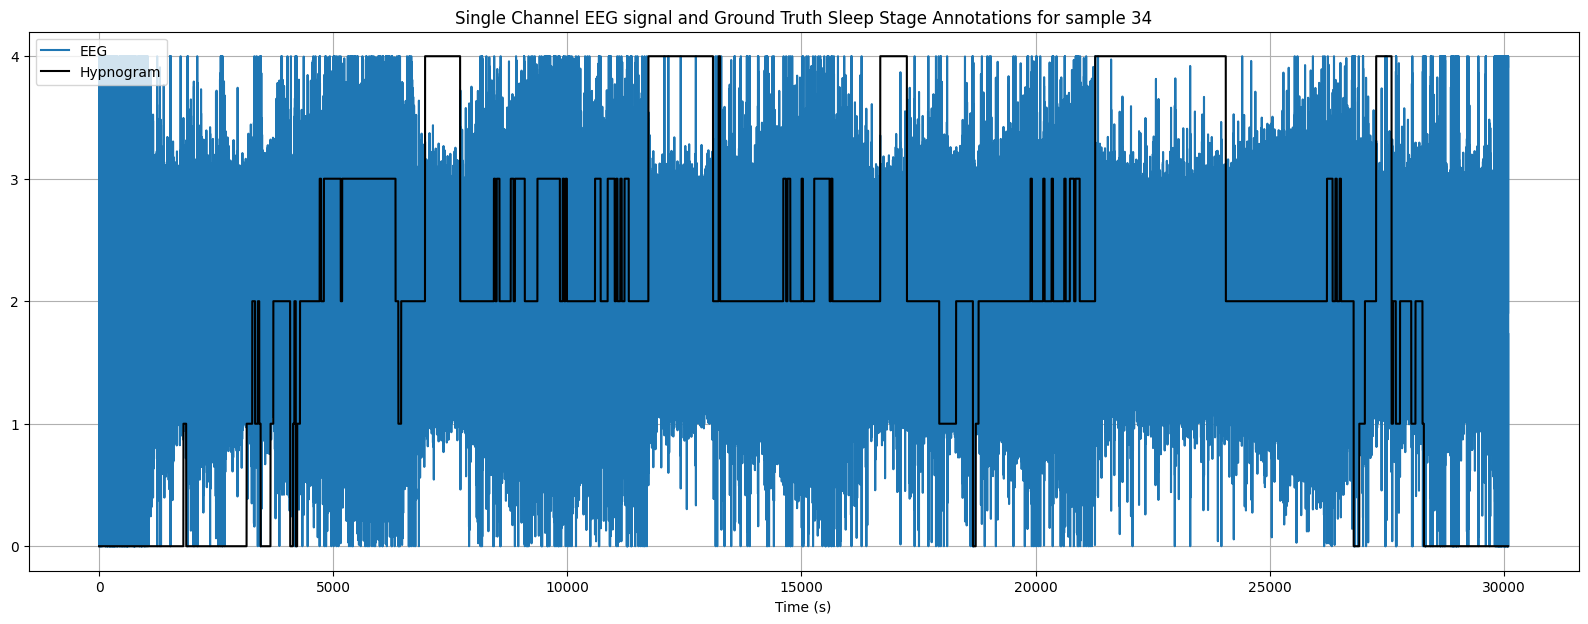

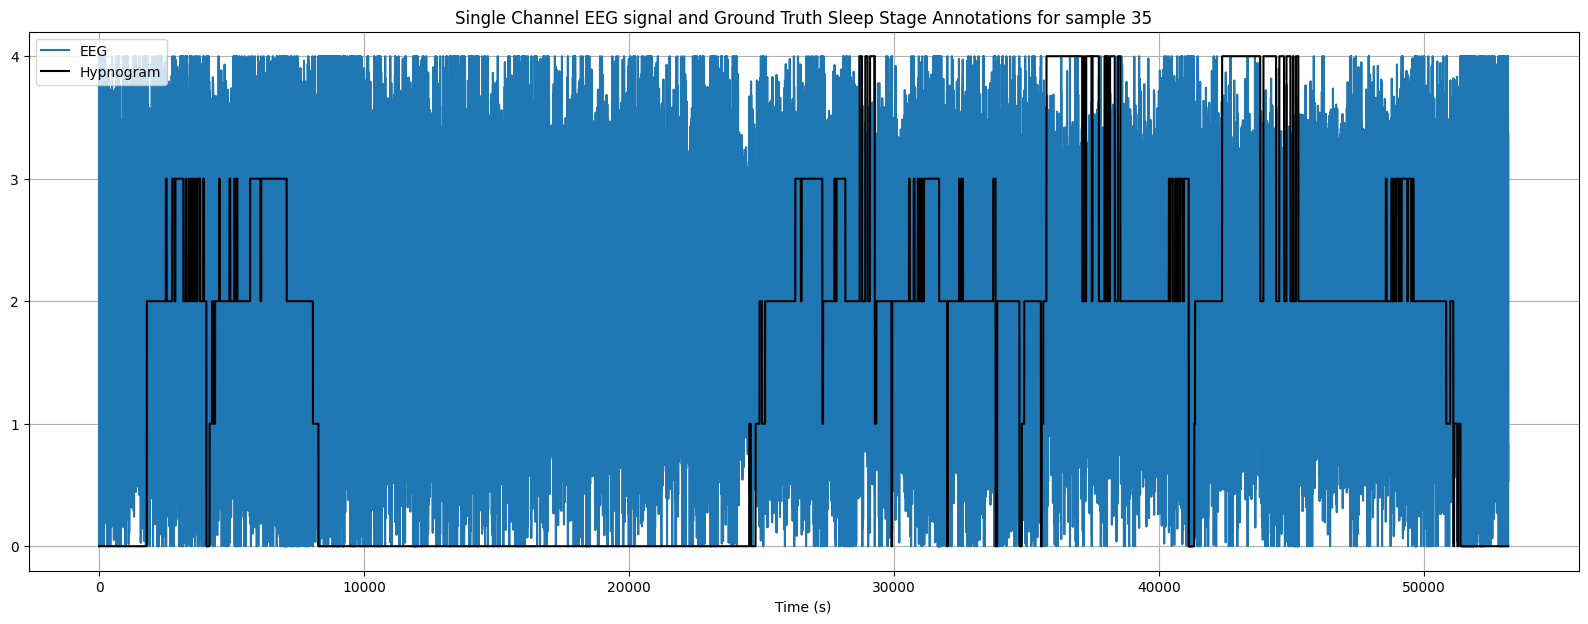

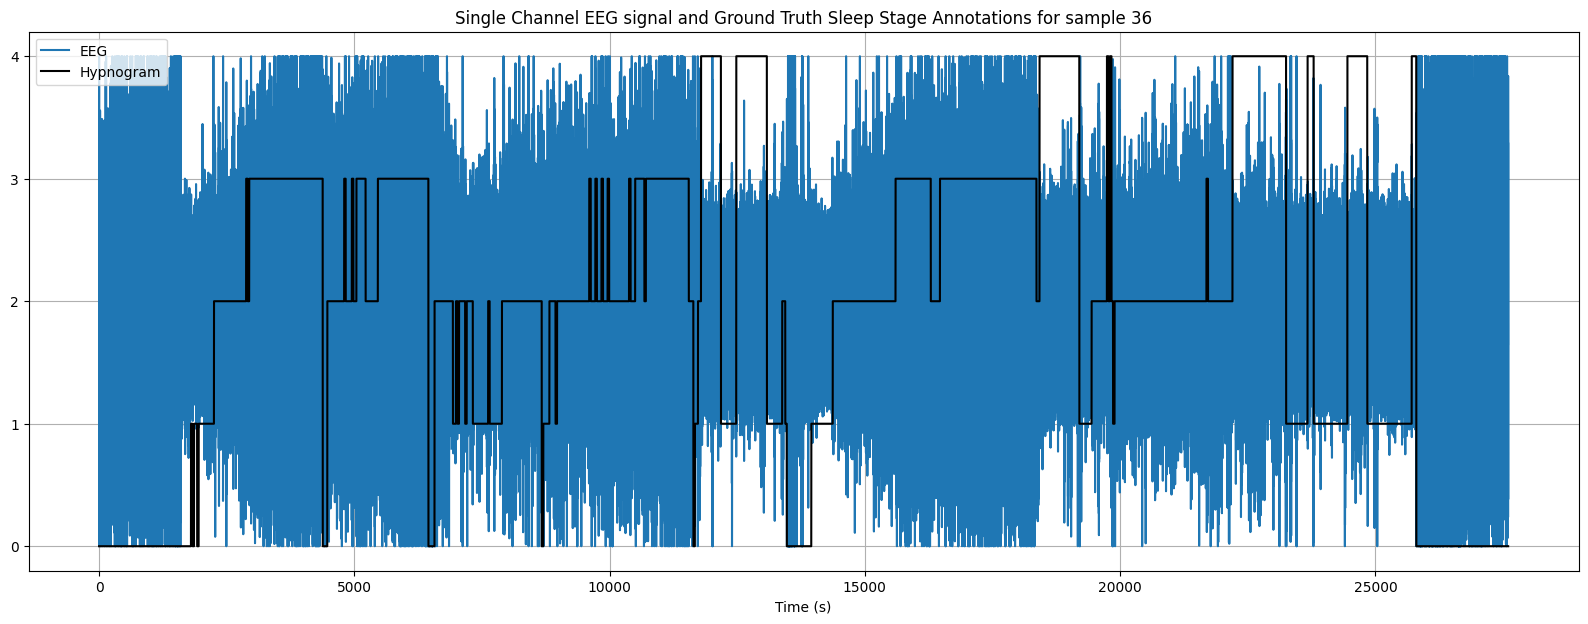

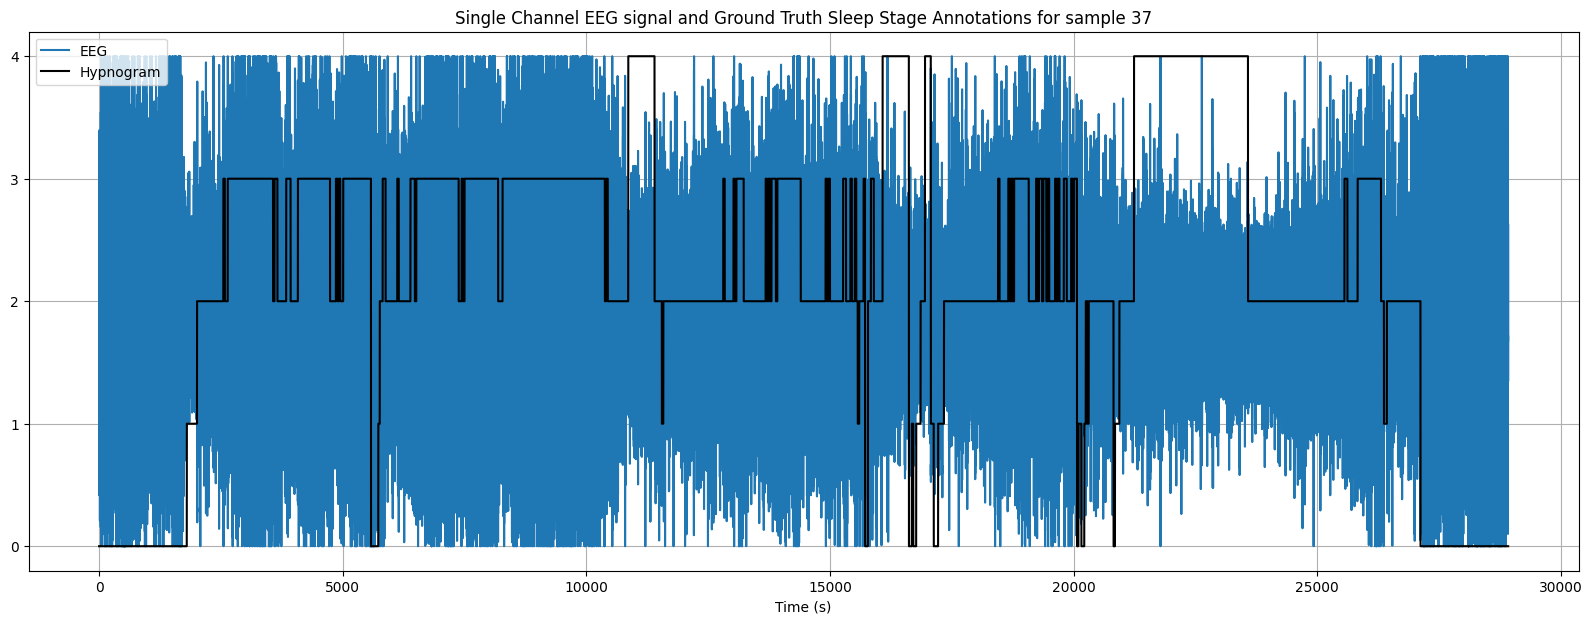

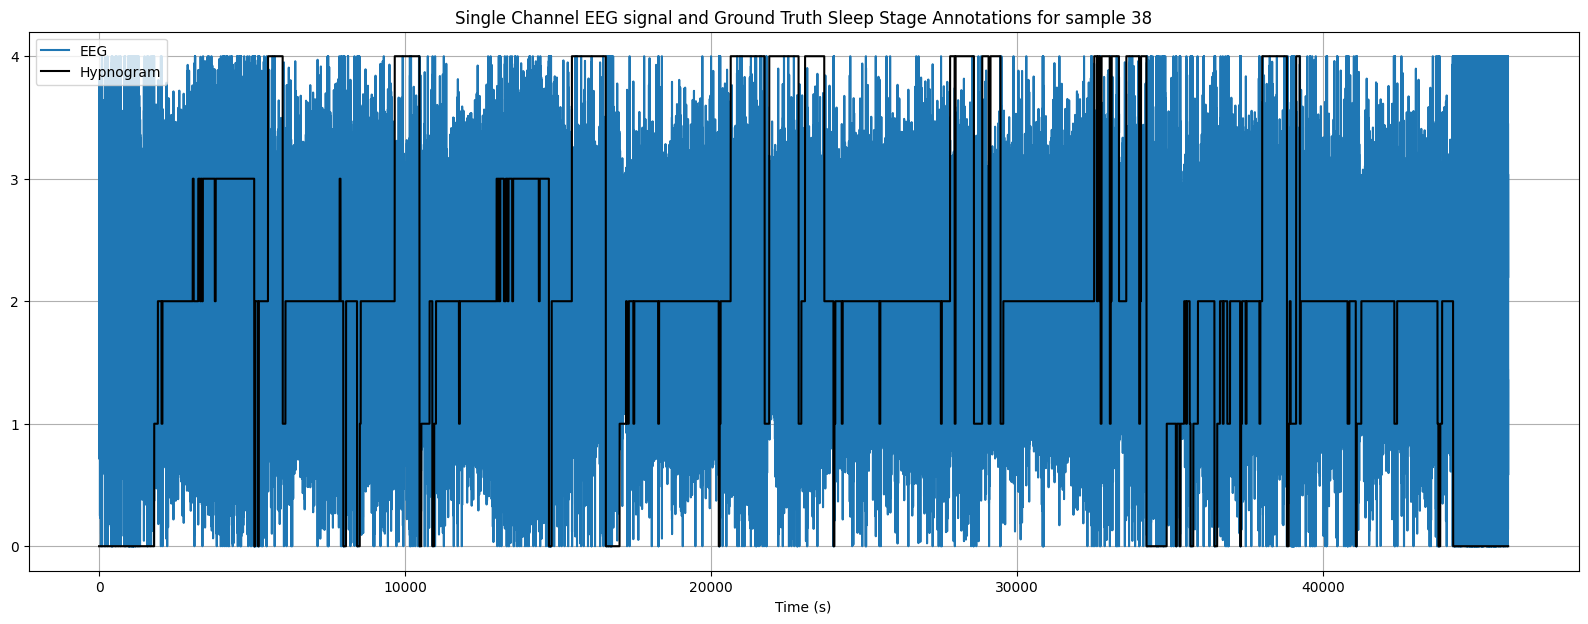

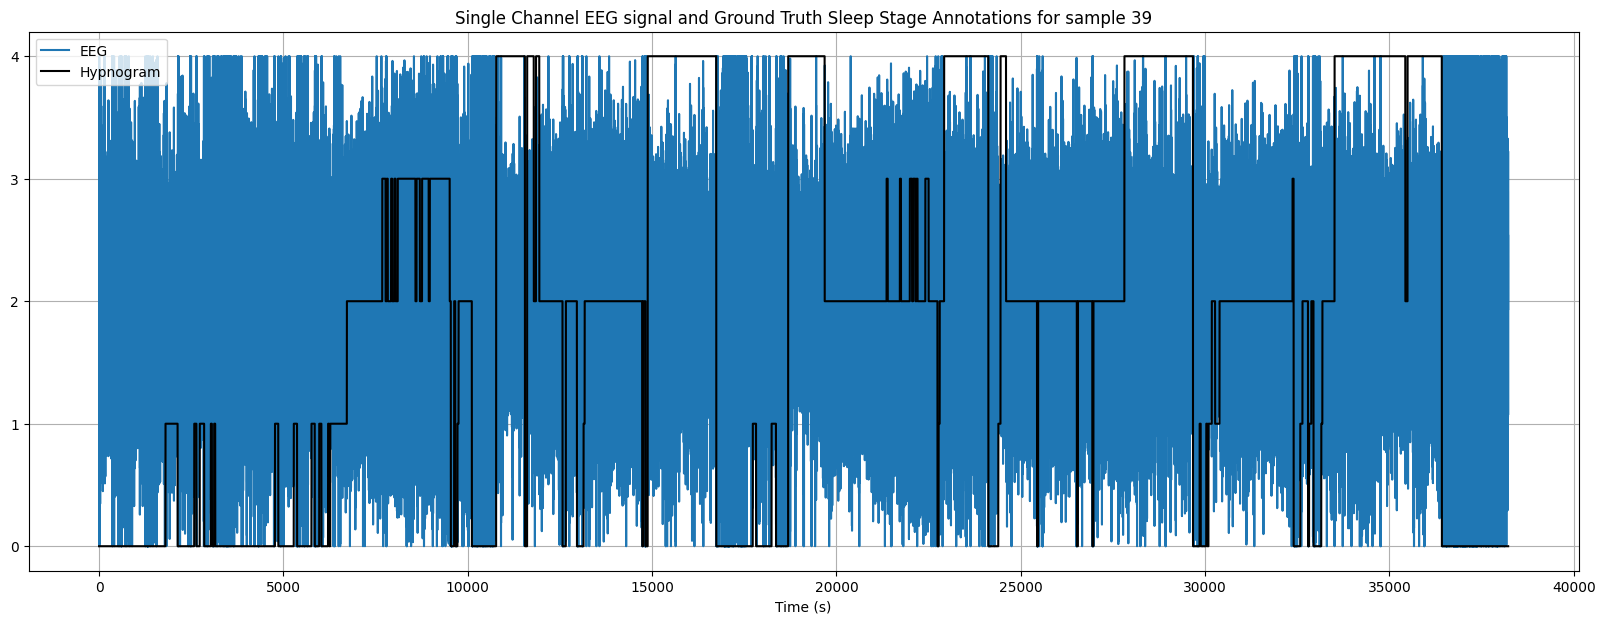

In [ ]:
files = os.listdir(filePath)
for i, file in enumerate(files):
    d = np.load(filePath+file, allow_pickle = True)
    scalar = MinMaxScaler(feature_range = (0, 4))
    x = scalar.fit_transform(d['x'][:,:,0])
    x = x.reshape(-1,)
    y = np.repeat(d['y'], 3000)
    t = np.arange(0, d['x'].shape[0]*d['x'].shape[1])/100

    figure = plt.figure( figsize = (20,7))
    plt.plot(t, x, label = "EEG")
    plt.plot(t, y, label = "Hypnogram", c = "k")
    plt.xlabel("Time (s)")
    plt.yticks([0, 1, 2, 3, 4])
    plt.grid()
    plt.title("Single Channel EEG signal and Ground Truth Sleep Stage Annotations for sample {}".format(i+1))
    plt.legend(loc = "upper left")
    plt.show()

In [ ]:
data_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}
for i in range(5):
    for j in range(len(Y)):
        if int(Y[j][0]) == i:
            data_dict[i].append(X[j])

In [ ]:
for i in range(5):
    data_dict[i] = np.array(data_dict[i], dtype = "int32")
    print(data_dict[i].shape)

(8285, 3000)
(2804, 3000)
(17799, 3000)
(5703, 3000)
(7717, 3000)


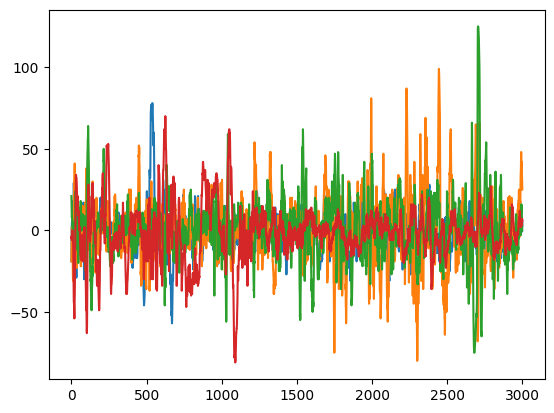

In [ ]:
import matplotlib.pyplot as plt
ind = [765, 6, 73, 645]
for i in ind:
  plt.plot(data_dict[2][i])

## Classical ML Approach:

### Feature extraction:

In [ ]:
ref_data = {}

for i in range(5):
    ind = np.random.choice(len(data_dict[i]), size=10, replace=False)
    temp = data_dict[i][ind]
    ref_data[i] = temp

In [ ]:
with open("ref_data.pkl", "wb") as f:
    pickle.dump(ref_data, f)

In [ ]:
# CREATE MATRIX MASK OF SHAPE (M,N)
M=128  #rows
N=3000  #columns

#ROW MASK
a=np.ndarray(shape=(M,N),dtype='int')
for row in range(M):
  for col in range(N):
    a[row][col]=row
print(f'row_mask: {a}')
np.save('/content/row_mask.npy',a)
#ROW MASK INVERSE
a=np.ndarray(shape=(M,N),dtype='int')
for row in range(M):
  for col in range(N):
    a[row][col]=M-1-row
print(f'row_mask inverse: {a}')
np.save('/content/row_mask_inverse.npy',a)
#COLUMN MASK
a=np.ndarray(shape=(M,N),dtype='int')
for row in range(M):
  for col in range(N):
    a[row][col]=col
print(f'column_mask: {a}')
np.save('/content/column_mask.npy',a)
#COLUMN MASK INVERSE
a=np.ndarray(shape=(M,N),dtype='int')
for row in range(M):
  for col in range(N):
    a[row][col]=N-1-col
print(f'row_mask: {a}')
np.save('/content/column_mask_inverse.npy',a)



row_mask: [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [125 125 125 ... 125 125 125]
 [126 126 126 ... 126 126 126]
 [127 127 127 ... 127 127 127]]
row_mask inverse: [[127 127 127 ... 127 127 127]
 [126 126 126 ... 126 126 126]
 [125 125 125 ... 125 125 125]
 ...
 [  2   2   2 ...   2   2   2]
 [  1   1   1 ...   1   1   1]
 [  0   0   0 ...   0   0   0]]
column_mask: [[   0    1    2 ... 2997 2998 2999]
 [   0    1    2 ... 2997 2998 2999]
 [   0    1    2 ... 2997 2998 2999]
 ...
 [   0    1    2 ... 2997 2998 2999]
 [   0    1    2 ... 2997 2998 2999]
 [   0    1    2 ... 2997 2998 2999]]
row_mask: [[2999 2998 2997 ...    2    1    0]
 [2999 2998 2997 ...    2    1    0]
 [2999 2998 2997 ...    2    1    0]
 ...
 [2999 2998 2997 ...    2    1    0]
 [2999 2998 2997 ...    2    1    0]
 [2999 2998 2997 ...    2    1    0]]


In [ ]:
def preprocess(X: np.ndarray) -> np.ndarray:
  #data = (X - np.min(X, axis=0))/(np.max(X, axis=0) - np.min(X, axis=0))
  m = np.mean(X, axis=0)
  s = np.std(X, axis=0)

  data = (X - m)/s
  return data               #(total_samples, num_featues)                 #(num_sleep_stages, total_samples, num_features)

def correntropy(x, y):
    #N = len(x)
    X=preprocess(x)
    Y=preprocess(y)
    s=np.std(X, axis=0)
    #print(f"std dev: {s}")
    V =  np.exp(-0.5*np.square(X - Y)/s**2)
    #CIP = 0.0 # mean in feature space should be subtracted!!
    #for i in range(0, N):
        #CIP += np.average(np.exp(-0.5*(x- y[i])**2/s**2))/N
    return V



def get_sums(W):
  path = '/content/'

  row_mask = np.load(path + 'row_mask.npy', allow_pickle=True)  #mask matrices have fixed shape for same scale and time i.shape/j.shape=(263,3750)
  column_mask = np.load(path + 'column_mask.npy', allow_pickle=True)  #for dj=1/24 and 30 second segments

  accum = np.multiply(W, np.multiply(row_mask, column_mask))
  accum = np.sum(accum)
  accum_sq = np.multiply(W, np.multiply(row_mask**2, column_mask**2))
  accum_sq = np.sum(accum_sq)

  return accum, accum_sq



def get_sums2(total_scales, total_time, W):

  ones = np.ones((total_scales, total_time))
  x = np.arange(total_scales).reshape(-1, 1)
  y = np.arange(total_time).reshape(1,-1)
  i = np.multiply(ones, x).astype(int)
  j = np.multiply(ones, y).astype(int)
  accum = np.multiply(W, np.multiply(i, j))  #kind of masking
  accum = np.sum(accum)
  accum_sq = np.multiply(W, np.multiply(i**2, j**2))
  accum_sq = np.sum(accum_sq)

  return accum, accum_sq


In [ ]:
def feature_gen(s1, s2, ref_label):

  #print(f"t1={t1}; s1={s1};")
  #print(f"t2={t2}; s2={s2}")
  #print(f"Length of s1={len(s1)}")
  #print(f"Length of s2={len(s2)}")
  #dt = np.diff(t1)[0]
  dt=1/125
  #W12_complex, cross_coi, freq, signif= wavelet.xwt(s1, s2, dt, dj=1/24, normalize=True)
  W12_complex, _, _, _= wavelet.xwt(s1, s2, dt, dj=1/12, normalize=True)                  #TAKING TOO MUCH TIME
  #R12, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/24, cache=True)
  #find_phase=np.vectorize(cmath.phase)
  W12_phase=np.abs(np.angle(W12_complex))                   #TAKING TOO MUCH TIME
  W12 = np.abs(W12_complex)   #row->scale, col->time
  assert(W12_phase.shape == W12_complex.shape)
  #print("****************************************")
  # print(W12)

  total_scales = W12.shape[0]
  total_time = W12.shape[1]

  accum, accum_sq = get_sums(W12)                             #TAKING TOO MUCH TIME
  accum_phase, accum_sq_phase=get_sums(W12_phase)             #TAKING TOO MUCH TIME

  W12_phase_sum=np.sum(W12_phase)
  W12_sum = np.sum(W12)
  #print(f"W12_sum:{W12_sum}")
  f1 = accum/W12_sum
  # try:
  #   f2 = np.sqrt(accum_sq/W12_sum)
  # except RuntimeWarning:
  #   f2 = 0
  f3 = W12_sum/np.max(W12)

  s_min, t_min = np.unravel_index(W12.argmin(), W12.shape)
  s_max, t_max = np.unravel_index(W12.argmax(), W12.shape)
  x = np.absolute((s_max - s_min) * (t_max - t_min))  #doubt

  eps = 1e-5
  f4 = W12_sum/(x+eps)
  f5 = np.sqrt((np.sum((np.square(f4 - W12))))/(x+eps))

  f6 = s_max     #doubt
  f7 = t_max      #doubt
  f8 = s_min      #doubt

  f9 = 0.5*W12_sum/(x+eps)
  f10 = np.sum(np.square(W12 ))
  f11 = f10/(x+eps)
  f12 = np.sqrt(f11)
  #f13 = np.exp(min(W12_sum/((x+eps)*10),700))
  #print(f"x is{W12_sum/(x*10)}")
  w=np.array(W12)
  s=0
  for i in range(1,total_scales):
    s+=np.sum(np.absolute(w[i,:]-w[i-1,:]))
    #for j in range(total_time):
      #s+=np.square(W12[i][j]-W12[i-1][j])
  consec_scale_diff=s
  '''
  print(f"consec_scale_diff:{consec_scale_diff}")
  s=0
  for j in range(1,total_time):
    s+=np.sum(np.absolute(w[:,j]-w[:,j-1]))             #TAKING TOO MUCH TIME
  consec_time_diff=s
  print(f"consec_time_diff:{consec_time_diff}")
  '''
  f14 = consec_scale_diff
  f15 = f14/(x+eps)
  f16 = np.sqrt((f14**2)/(x+eps))
  f17 = np.log10(f14)
  f18 = W12_sum
  f19 = accum_phase/W12_phase_sum
  f20 = np.sqrt(accum_sq_phase/W12_phase_sum)
  f21 = W12_phase_sum
  f22 = W12_phase_sum/(np.max(W12_phase))
  f23 = W12_phase_sum/(x+eps)
  f24 = np.sqrt((np.sum(np.square((f22-W12_phase))))/(x+eps))
  f25 = 0.5*(W12_phase_sum)/(x+eps)
  mean_class_vector=[]
  #for ref_segment in ref_segments[ref_label]:
    #mean_class_vector.append(np.array(ref_segment))
  #print(np.shape(ref_segment))
  #print(f"shape of mean class vector: {np.shape(mean_class_vector)}")
  #mcv=np.mean(mean_class_vector,axis=0)
  f26 = np.sqrt(np.sum(np.square(s1-s2)))     #euclidean distance between s1 and mcv ?
  f27 = cosine_similarity(s1.reshape(1,-1),s2.reshape(1,-1), dense_output=True).reshape(1,1)[0][0]

  corr=correntropy(s1,s2)
  f28=np.mean(corr)
  f29=kurtosis(corr)
  f30=skew(corr)
  f31=moment(corr,moment=2)
  f32=moment(corr,moment=3)
  f33=trim_mean(corr,0.1)


  f = [f1,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33]
  # removed f2 for RuntimeWarning: invalid value encountered in sqrt
  F = []
  for i in f:
    F.append(i)
  # for i in range(len(F)):
  #   print(f"F{i+1}: {F[i]}")
  return np.array(F)

In [ ]:
from multiprocessing import Pool

n = len(X)
X_transformed = []
for i in tqdm(range(n//2)):
    feat_temp = []
    for ind in range(5):
        for j in range(len(ref_data[ind])):
            temp = feature_gen(X[i], ref_data[ind][j], Y[i][0])
            feat_temp.append(temp)
    feat_temp = np.array(feat_temp, dtype = np.float64)
    # print("\n", feat_temp.shape)
    feat_temp = np.mean(feat_temp, axis=0)
    # print(feat_temp.shape)
    X_transformed.append(temp)
X_transformed = np.array(X_transformed, dtype = 'float32')
print(X_transformed.shape, Y.shape)

100%|██████████| 21154/21154 [16:25:30<00:00,  2.80s/it]

(21154, 31) (42308, 1)


This takes a lot of time even for half of the data.\
So we have to save it.

In [ ]:
# data_trans = (X_transformed, Y[:n//2, :])
# with open("/content/drive/MyDrive/Datasets/SleepData_simpler/Extracted_features/ref_data.pkl", "wb") as f:
#     pickle.dump(data_trans, f)

In [ ]:
with open("/content/drive/MyDrive/Datasets/SleepData_simpler/Extracted_features/ref_data.pkl", "rb") as f:
    X_transformed, Y_transformed = pickle.load(f)

with open("/content/drive/MyDrive/Datasets/SleepData_simpler/Extracted_features/ref_data_complementary.pkl", "rb") as f:
    X_transformed1, Y_transformed1 = pickle.load(f)

X_transformed = np.concatenate([X_transformed, X_transformed1], axis = 0)
Y_transformed = np.concatenate([Y_transformed, Y_transformed1], axis = 0)

In [ ]:
import random
n = len(X_transformed)
ind = random.choice(np.arange(n))
print("Label of index: {} is {} and data:".format(ind, int(Y_transformed[ind][0])))
print(X_transformed[ind])

Label of index: 25091 is 2 and data:
[ 1.0750479e+05  1.8218025e+04  6.4781273e+01  2.3731342e+02
  7.9000000e+01  7.0400000e+02  0.0000000e+00  3.2390636e+01
  3.4616032e+07  1.3608000e+03  3.6889023e+01  3.7459047e+05
  1.4725626e+01  2.3486335e+03  5.5735569e+00  1.6479060e+06
  8.0477586e+04  1.0668606e+05  5.2766631e+05  1.6796156e+05
  2.0743231e+01  6.5257506e+05  1.0371615e+01  1.1575963e+03
  6.4267870e-03  6.0419178e-01 -1.2186731e+00 -4.5830300e-01
  1.1199980e-01 -1.7178237e-02  6.2761158e-01]


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y_transformed[:, 0], test_size = 0.15)
X_train.shape, X_test.shape, Y_train.shape

((35961, 31), (6347, 31), (35961,))

              precision    recall  f1-score   support

         0.0       0.59      0.42      0.49      1175
         1.0       0.46      0.07      0.13       488
         2.0       0.62      0.83      0.71      2722
         3.0       0.72      0.71      0.71       837
         4.0       0.47      0.40      0.43      1125

    accuracy                           0.61      6347
   macro avg       0.57      0.49      0.50      6347
weighted avg       0.59      0.61      0.58      6347



<Axes: >

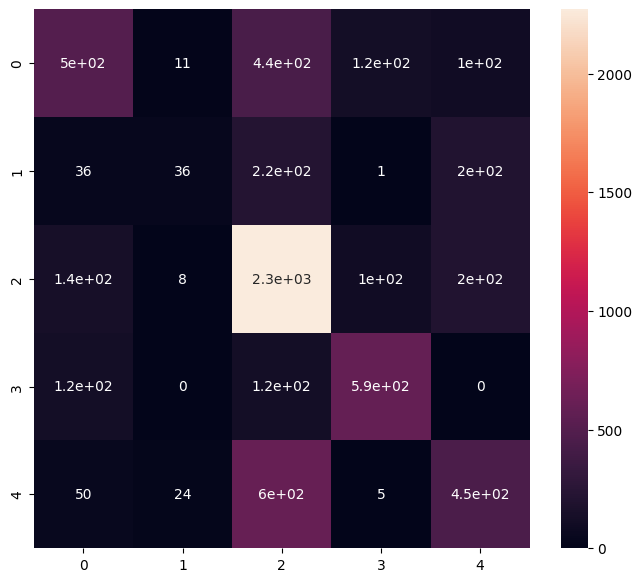

In [ ]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, Y_train)
Y_pred = model_rfc.predict(X_test)
print(classification_report(Y_test, Y_pred))
fig = plt.figure(figsize = (8, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot = True)

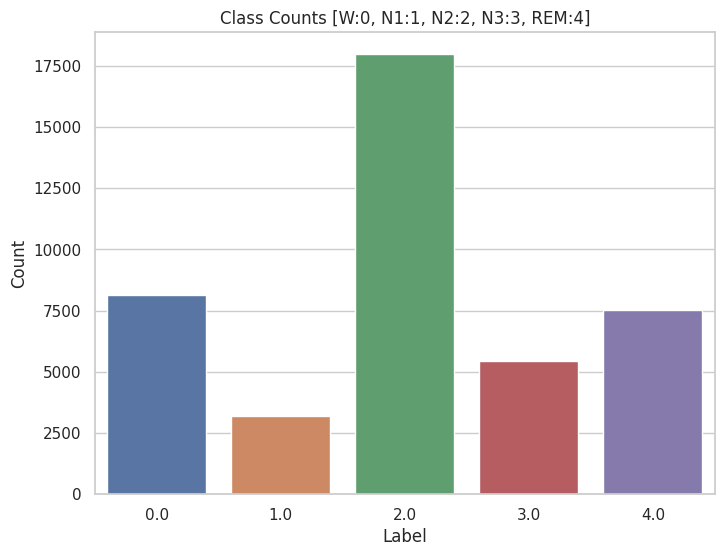

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=Y_transformed[:, 0])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Class Counts [W:0, N1:1, N2:2, N3:3, REM:4]")
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

oversample = SMOTE(sampling_strategy = "not majority", k_neighbors=10, n_jobs = -1)
X, Y = oversample.fit_resample(X_train, Y_train)
# summarize distribution
counter = Counter(Y)
for k,v in counter.items():
  per = v / len(Y) * 100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
X.shape, Y.shape

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Class=0, n=15255 (20.000%)
Class=3, n=15255 (20.000%)
Class=4, n=15255 (20.000%)
Class=2, n=15255 (20.000%)
Class=1, n=15255 (20.000%)


((76275, 31), (76275,))

              precision    recall  f1-score   support

         0.0       0.51      0.48      0.49      1175
         1.0       0.25      0.31      0.27       488
         2.0       0.68      0.62      0.65      2722
         3.0       0.67      0.75      0.71       837
         4.0       0.42      0.47      0.44      1125

    accuracy                           0.56      6347
   macro avg       0.51      0.52      0.51      6347
weighted avg       0.57      0.56      0.56      6347



<Axes: >

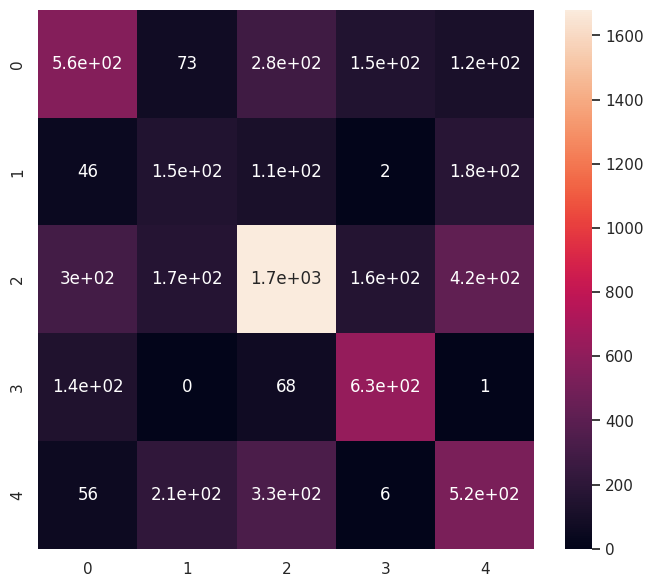

In [ ]:
model_rfc2 = RandomForestClassifier()
model_rfc2.fit(X, Y)
Y_pred = model_rfc2.predict(X_test)
print(classification_report(Y_test, Y_pred))
fig = plt.figure(figsize = (8, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot = True)

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)
models


 97%|█████████▋| 28/29 [06:19<00:22, 22.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 35961, number of used features: 31
[LightGBM] [Info] Start training from score -1.640820
[LightGBM] [Info] Start training from score -2.586963
[LightGBM] [Info] Start training from score -0.857528
[LightGBM] [Info] Start training from score -2.051824
[LightGBM] [Info] Start training from score -1.724732


100%|██████████| 29/29 [06:20<00:00, 13.13s/it]


Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.62               0.51    None      0.59   
XGBClassifier                      0.61               0.51    None      0.59   
RandomForestClassifier             0.61               0.49    None      0.58   
BaggingClassifier                  0.58               0.49    None      0.57   
SVC                                0.60               0.46    None      0.56   
ExtraTreesClassifier               0.59               0.46    None      0.56   
AdaBoostClassifier                 0.55               0.43    None      0.50   
LogisticRegression                 0.57               0.42    None      0.53   
DecisionTreeClassifier             0.47               0.42    None      0.48   
LinearSVC                          0.56               0.40    None      0.49   
KNeighborsClassifier               0.51               0.40    None      0.48   
CalibratedClassifierCV             0.56               0.40    None      0.50   
SGDClassifier                      0.50               0.39    None      0.45   
PassiveAggressiveClassifier        0.45               0.39    None      0.44   
LabelSpreading                     0.45               0.39    None      0.45   
LabelPropagation                   0.45               0.39    None      0.45   
LinearDiscriminantAnalysis         0.55               0.39    None      0.49   
BernoulliNB                        0.46               0.38    None      0.43   
NearestCentroid                    0.38               0.38    None      0.38   
RidgeClassifierCV                  0.54               0.37    None      0.47   
RidgeClassifier                    0.54               0.37    None      0.47   
ExtraTreeClassifier                0.42               0.36    None      0.42   
Perceptron                         0.42               0.36    None      0.42   
GaussianNB                         0.23               0.27    None      0.15   
DummyClassifier                    0.43               0.20    None      0.26   
QuadraticDiscriminantAnalysis      0.22               0.19    None      0.20   

                               Time Taken  
Model                                      
LGBMClassifier                       1.45  
XGBClassifier                       26.04  
RandomForestClassifier              18.68  
BaggingClassifier                   10.68  
SVC                                 94.77  
ExtraTreesClassifier                 5.69  
AdaBoostClassifier                   6.62  
LogisticRegression                   0.93  
DecisionTreeClassifier               1.68  
LinearSVC                           24.98  
KNeighborsClassifier                 0.61  
CalibratedClassifierCV             102.58  
SGDClassifier                        0.75  
PassiveAggressiveClassifier          0.26  
LabelSpreading                      62.09  
LabelPropagation                    21.23  
LinearDiscriminantAnalysis           0.27  
BernoulliNB                          0.09  
NearestCentroid                      0.12  
RidgeClassifierCV                    0.24  
RidgeClassifier                      0.10  
ExtraTreeClassifier                  0.09  
Perceptron                           0.35  
GaussianNB                           0.07  
DummyClassifier                      0.05  
QuadraticDiscriminantAnalysis        0.11

In [ ]:
%%time
def objective(trial):
    dtrain = lgbm.Dataset(X_train, label=Y_train)

    param = {
        "objective": "binary",
        'device': 'cpu',
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'learning_rate':trial.suggest_float("learning_rate", 1e-8, 0.5, log=True),
        "n_estimators" : trial.suggest_int('n_estimators', 100, 1600,10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgbm.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    score = f1_score(Y_test, pred_labels,  average='macro')
    return score



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
lgbm1_params = study.best_params

In [ ]:
print("Best parameters for LGBM Classifier:")
print(lgbm1_params)

Best parameters for LGBM Classifier:
{'learning_rate': 0.014111749440949698, 'n_estimators': 580, 'lambda_l1': 2.2517002675815404e-08, 'lambda_l2': 0.9628291745675873, 'num_leaves': 35, 'feature_fraction': 0.8611143938201575, 'bagging_fraction': 0.5607459055435797, 'bagging_freq': 7, 'min_child_samples': 98}


Best parameters for LGBM Classifier:\
{'learning_rate': 0.014111749440949698, 'n_estimators': 580, 'lambda_l1': 2.2517002675815404e-08, 'lambda_l2': 0.9628291745675873, 'num_leaves': 35, 'feature_fraction': 0.8611143938201575, 'bagging_fraction': 0.5607459055435797, 'bagging_freq': 7, 'min_child_samples': 98}

In [ ]:
lgbm1_params = {'learning_rate': 0.014111749440949698,
                'n_estimators': 580,
                'lambda_l1': 2.2517002675815404e-08,
                'lambda_l2': 0.9628291745675873,
                'num_leaves': 35,
                'feature_fraction': 0.8611143938201575,
                'bagging_fraction': 0.5607459055435797,
                'bagging_freq': 7,
                'min_child_samples': 98}
model_classifier = lgbm.LGBMClassifier(**lgbm1_params, verbose = -1)
model_classifier.fit(X_train, Y_train)

# Make predictions on the validation set
y_pred_cv = model_classifier.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred_cv)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(Y_test, y_pred_cv))


Accuracy: 0.6165117378288956
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.45      0.51      1175
         1.0       0.45      0.13      0.20       488
         2.0       0.65      0.81      0.72      2722
         3.0       0.72      0.73      0.72       837
         4.0       0.46      0.46      0.46      1125

    accuracy                           0.62      6347
   macro avg       0.58      0.51      0.52      6347
weighted avg       0.60      0.62      0.60      6347



## Deep Learning Approach:

In [ ]:
import pickle
with open("/content/drive/MyDrive/Datasets/SleepData_simpler/total_data.pkl", "rb") as f:
    X, Y = pickle.load(f)

X.shape, Y.shape

((39, 1200, 3000, 1), (39, 1200, 5))

In [ ]:
X.min(), X.max(), X.mean()

(-5.0, 5.0000014, -0.1461748)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15)
X_train.shape, X_test.shape

((33, 1200, 3000, 1), (6, 1200, 3000, 1))

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 42.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import tensorflow_addons as tfa
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers import Conv1D, Add, Concatenate, Reshape
from keras.layers import Dropout, SpatialDropout1D
from keras.layers import Dense, TimeDistributed, Bidirectional
from keras.layers import GlobalAveragePooling1D, MaxPooling1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

modelPath = '/content/drive/MyDrive/Datasets/SleepData_simpler/Weights_v4/'


def focal_loss_custom(alpha, gamma):
    def binary_focal_loss(y_true, y_pred):

        fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
        # pred_argmax = np.argmax(np.round(y_pred), axis=1)
        # pred_argmax_tensor = tf.convert_to_tensor(pred_argmax, dtype=tf.float32)
        # y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_true_K = K.ones_like(y_true)
        focal_loss = fl(y_true, y_pred)
        # focal_loss = tf.reduce_mean(focal_loss)
        return focal_loss
    return binary_focal_loss

# def epochEncoder():
#     """
#     This is a sub-model that encodes each 30-second EEG epoch into a 1D vector.
#     A 1D CNN is used to encode the epochs.
#     """
#     input_layer = Input(shape=(3000, 1))

#     # First CNN with small filter size
#     cnn_small = Conv1D(filters=64, kernel_size=48, strides = 6, activation='relu', padding="same")(input_layer)
#     cnn_small = MaxPooling1D(pool_size=8, strides = 8)(cnn_small)
#     cnn_small = Dropout(0.5)(cnn_small)
#     cnn_small = Conv1D(filters=64, kernel_size=8, activation='relu', padding="same")(cnn_small)
#     cnn_small = Conv1D(filters=64, kernel_size=8, activation='relu', padding="same")(cnn_small)
#     cnn_small = Conv1D(filters=64, kernel_size=8, activation='relu', padding="same")(cnn_small)
#     cnn_small = MaxPooling1D(pool_size=4, strides = 4)(cnn_small)

#     # Second CNN with large filter size
#     cnn_large = Conv1D(filters=64, kernel_size=384, strides = 48,  activation='relu', padding="same")(input_layer)
#     cnn_large = MaxPooling1D(pool_size=2, strides = 2)(cnn_large)
#     cnn_large = Dropout(0.5)(cnn_large)
#     cnn_large = Conv1D(filters=64, kernel_size=6, activation='relu', padding="same")(cnn_large)
#     cnn_large = Conv1D(filters=64, kernel_size=6, activation='relu', padding="same")(cnn_large)
#     cnn_large = Conv1D(filters=64, kernel_size=6, activation='relu', padding="same")(cnn_large)
#     cnn_large = MaxPooling1D(pool_size=2, strides = 2)(cnn_large)


#     # Concatenate CNN outputs
#     concatenated_features = Concatenate(axis=-1)([cnn_small, cnn_large])
#     concatenated_features = Dropout(0.5)(concatenated_features)
#     concatenated_features = GlobalAveragePooling1D()(concatenated_features)



#     epochEncoder = Model(inputs=input_layer, outputs=concatenated_features)

# #     epochEncoder.compile(optimizer=Adam(0.001), loss= focal_loss_custom(alpha=4.0, gamma=2.0), metrics=['acc'])
#     epochEncoder.compile(optimizer='nadam',
#                          loss= tf.keras.losses.CategoricalFocalCrossentropy(alpha = 0.5, gamma = 3.0), #focal_loss_custom(alpha=4.0, gamma=2.0),
#                          metrics=['acc'])

#     return epochEncoder

def epochEncoder():
    """
    This is a sub-model that encodes each 30-second EEG epoch into a 1D vector.
    A 1D CNN is used to encode the epochs.
    """
    # we are dealing with time series data
    inputShape = Input(shape=(3000, 1))

    x = Conv1D(16, kernel_size=5, activation="relu", padding="valid")(inputShape)
    x = Conv1D(16, kernel_size=5, activation="relu", padding="valid")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(rate=0.01)(x)

    x = Conv1D(32, kernel_size=3, activation="relu", padding="valid")(x)
    x = Conv1D(32, kernel_size=3, activation="relu", padding="valid")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(rate=0.01)(x)

    x = Conv1D(32, kernel_size=3, activation="relu", padding="valid")(x)
    x = Conv1D(32, kernel_size=3, activation="relu", padding="valid")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(rate=0.01)(x)

    x = Conv1D(256, kernel_size=3, activation="relu", padding="valid")(x)
    x = Conv1D(256, kernel_size=3, activation="relu", padding="valid")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(rate=0.01)(x)

    denseOne = Dropout(0.01)(Dense(64, activation="relu", name="denseOne")(x))

    epochEncoder = Model(inputs=inputShape, outputs=denseOne)
    optAdam = Adam(0.001)

    # epochEncoder.compile(optimizer=optAdam, loss="categorical_crossentropy", metrics=['acc'])
    epochEncoder.compile(optimizer='nadam',
                         loss= tf.keras.losses.CategoricalFocalCrossentropy(), #focal_loss_custom(alpha=4.0, gamma=2.0),
                         metrics=['acc'])

    return epochEncoder

def epochLabeller(epochEncoder):
    """
    This is a sub-model that labels a sequence of EEG epochs encoded the by the first model.
    A 1D CNN is used to label the epochs.
    """
    # classify epoch as either "W", "N1", "N2", "N3", or "REM"
    numClass = 5

    seqInput = Input(shape=(None, 3000, 1))

    # apply the first sub-model to each EEG epoch
    encodedSequence = TimeDistributed(epochEncoder)(seqInput)
    bi_lstm = Bidirectional(LSTM(units=128, return_sequences=True))(encodedSequence)

    out = TimeDistributed(Dropout(rate=0.5))(bi_lstm)
    skip_path = TimeDistributed(Dense(256, activation="relu", name="dense_skip"))(encodedSequence)
    out = Add()([bi_lstm, skip_path])
    out = SpatialDropout1D(rate=0.5)(out)
    out = Conv1D(numClass, kernel_size=3, activation="softmax", padding="same", name = "Output")(out)

    epochLabeller_model = Model(seqInput, out)
    epochLabeller_model.compile(optimizer='nadam', loss= tf.keras.losses.CategoricalFocalCrossentropy(alpha = 0.5, gamma = 3.0), #focal_loss_custom(alpha=4.0, gamma=2.0),
                                metrics=['acc', tf.keras.metrics.AUC(name = 'auc'), tf.keras.metrics.Precision(name = "precision")])

    return epochLabeller_model

# stack the two sub-models
epochEncoder = epochEncoder()
model = epochLabeller(epochEncoder)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, 3000, 1)]      0         []                            
                                                                                                  
 time_distributed_3 (TimeDi  (None, None, 64)             250416    ['input_4[0][0]']             
 stributed)                                                                                       
                                                                                                  
 bidirectional_1 (Bidirecti  (None, None, 256)            197632    ['time_distributed_3[0][0]']  
 onal)                                                                                            
                                                                                            

In [ ]:
model.load_weights(modelPath)

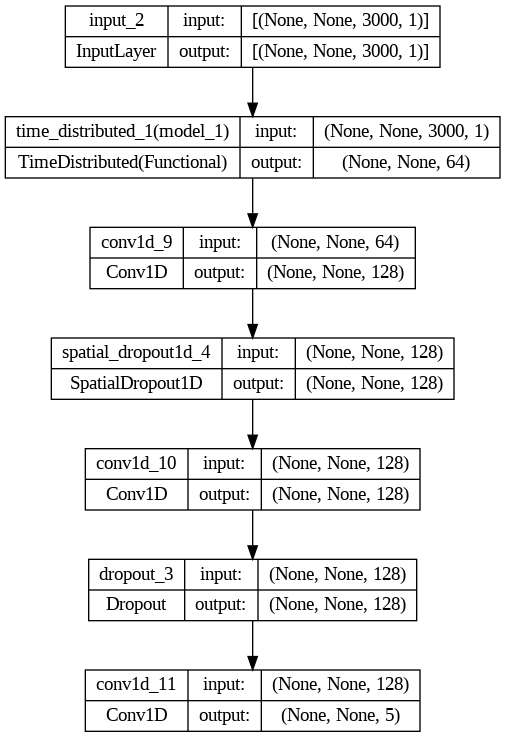

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='Entire_model_plot.png', show_shapes=True, show_layer_names=True)
# plot_model(epochEncoder, to_file='Encoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
checkPoint = ModelCheckpoint(modelPath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only = True, mode='min')
earlyStop = EarlyStopping(monitor="val_loss", mode="min", patience=20, verbose=1)
reduceOnPlat = ReduceLROnPlateau(monitor="val_loss", mode="min", patience=5, verbose=2)
callbacksList = [checkPoint, earlyStop, reduceOnPlat]

# train and save the model
# model.fit(generator(trainDict), validation_data=generator(valDict), epochs=100, verbose=1, steps_per_epoch=1000, validation_steps=300, callbacks=callbacksList)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, verbose=2, batch_size = 2, callbacks=callbacksList)

model.save(modelPath + "CnnV3.keras")

Epoch 1/200


InvalidArgumentError: ignored

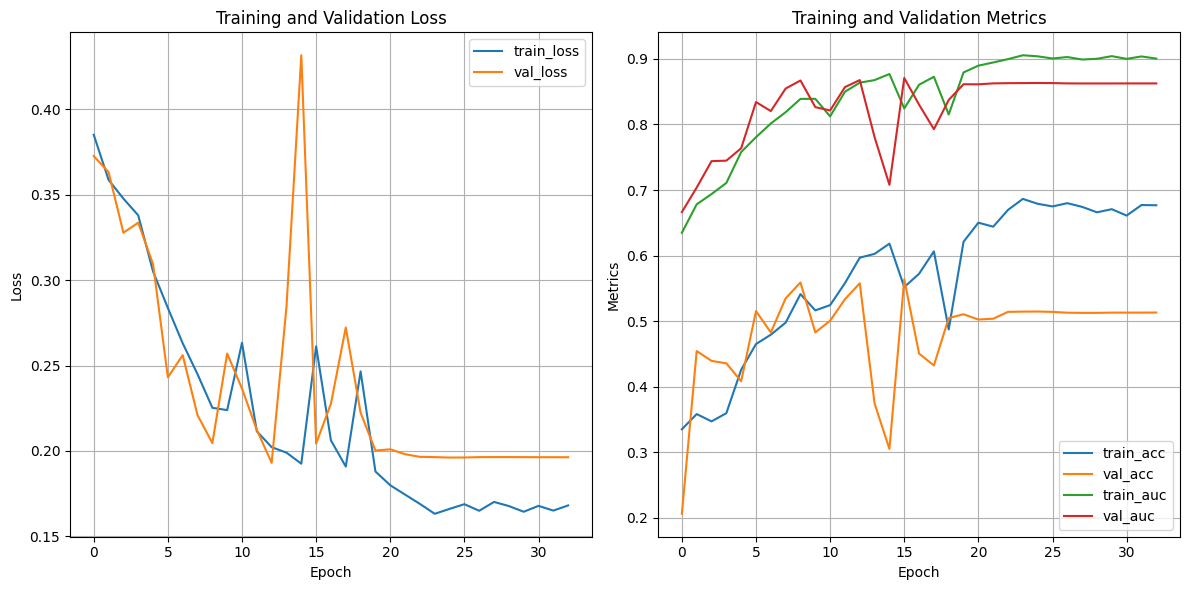

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, metrics=None):
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.legend()

    # Plot metrics
    if metrics is not None:
        plt.subplot(1, 2, 2)
        for metric in metrics:
            plt.plot(history.history[metric], label=f'train_{metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.xlabel('Epoch')
        plt.ylabel('Metrics')
        plt.title('Training and Validation Metrics')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

# Specify the metrics you want to plot (e.g., ['acc', 'auc'])
metrics_to_plot = ['acc', 'auc']

# Plot the training history
plot_training_history(history, metrics_to_plot)


We don't have enough data to train such a big model. We have to Augment our data.

In [ ]:
model1 = tf.keras.models.load_model('/content/cnnFinal.h5')
# model.load_weights('/content/cnnFinal.h5')


1/1 [==============================] - 0s 354ms/step


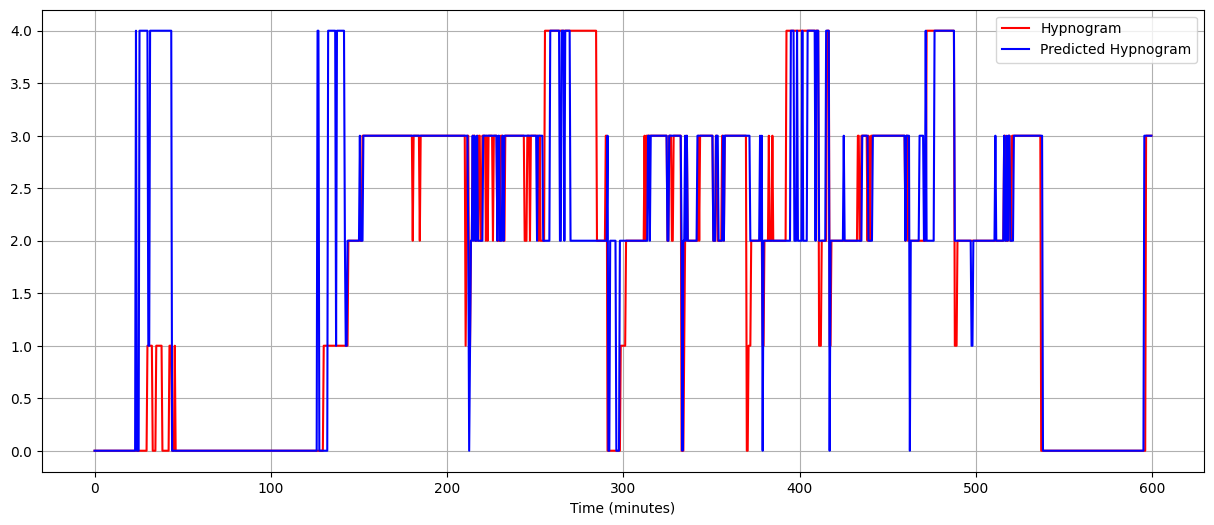


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      1452
           1       0.49      0.11      0.17       462
           2       0.74      0.78      0.76      2952
           3       0.57      0.95      0.72       865
           4       0.68      0.56      0.61      1469

    accuracy                           0.71      7200
   macro avg       0.66      0.63      0.61      7200
weighted avg       0.71      0.71      0.70      7200



In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Y_pred = model1.predict(X_test)

ind = random.choice(np.arange(len(X_test)))
dummy_Y_act = np.argmax(Y_test[ind].reshape(-1,5), axis = -1)
dummy_Y_pred = np.argmax(Y_pred[ind].reshape(-1,5), axis = -1)
t = np.arange(0, len(dummy_Y_act)*0.5, 0.5)

fig = plt.figure(figsize = (15, 6))
plt.plot(t, dummy_Y_act, c = 'r', label = "Hypnogram")
plt.plot(t, dummy_Y_pred, c = 'b', label = "Predicted Hypnogram")
plt.grid()
plt.xlabel("Time (minutes)")
plt.legend()
plt.show()


print("\nClassification Report:\n", classification_report(np.argmax(Y_test.reshape(-1, 5), axis = -1), np.argmax(Y_pred.reshape(-1, 5), axis = -1)))


In [ ]:
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 3000, 1)]   0         
                                                                 
 time_distributed_1 (TimeDi  (None, None, 64)          250416    
 stributed)                                                      
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         24704     
                                                                 
 spatial_dropout1d_4 (Spati  (None, None, 128)         0         
 alDropout1D)                                                    
                                                                 
 conv1d_10 (Conv1D)          (None, None, 128)         49280     
                                                                 
 dropout_3 (Dropout)         (None, None, 128)         0   